In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Importation des données

On pourrait expliquer ici l'origine des données etc

In [ ]:
df1 = pd.read_csv("soil_data.csv", sep=",")
df2 = pd.read_csv("test_timeseries.csv", sep=",")

In [ ]:
df1.head() #Contient les différents états des US avec des caractéristiques géographiques sur les états

fips        lat        lon  elevation  slope1  slope2  slope3  slope4  \
0  1001  32.536382 -86.644490         63  0.0419  0.2788  0.2984  0.2497   
1  1005  31.870670 -85.405456        146  0.0158  0.1868  0.5441  0.2424   
2  1003  30.659218 -87.746067         52  0.0746  0.4370  0.4415  0.0469   
3  1007  33.015893 -87.127148         93  0.0144  0.1617  0.3714  0.3493   
4  1009  33.977448 -86.567246        198  0.0050  0.0872  0.2799  0.3576   

   slope5  slope6  ...  CULTRF_LAND  CULTIR_LAND  CULT_LAND  SQ1  SQ2  SQ3  \
0  0.1142  0.0170  ...    56.293411     1.014811  57.308224    1    1    1   
1  0.0106  0.0003  ...    72.578804     1.828159  74.406960    3    2    1   
2  0.0000  0.0000  ...    59.843639     2.996914  62.840553    3    2    1   
3  0.0898  0.0134  ...     1.916593     0.008330   1.924924    3    2    1   
4  0.1477  0.1037  ...     1.891909     0.027488   1.919397    3    2    1   

   SQ4  SQ5  SQ6  SQ7  
0    1    1    1    2  
1    1    1    1    1  
2    2    1    1    1  
3    1    1    1    1  
4    1    1    1    1  

[5 rows x 32 columns]

In [ ]:
df2.head() #contient pour chaque état des scores de sécheresse sur 2 ans du 1 er janvier 2019 au 31 décembre 2020, en fonction des indices métérologiques journaliers

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2019-01-01     2.25  100.51  9.69  14.71   13.55   13.52    17.38   
1  1001  2019-01-02     4.94  100.48  8.65  13.05   11.83   11.74    17.76   
2  1001  2019-01-03    20.74  100.03  8.59  12.12   11.67   11.67    13.74   
3  1001  2019-01-04    16.17   99.47  7.93  11.80   10.38    9.59    18.19   
4  1001  2019-01-05     0.01  100.39  5.32   7.91    4.73    4.71    14.37   

   T2M_MIN  ...     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    10.92  ...  14.63   1.20       1.50       0.79         0.71   2.74   
1     9.54  ...  13.06   1.02       1.35       0.32         1.03   2.13   
2    10.44  ...  12.12   1.83       4.23       0.34         3.88   3.41   
3     5.44  ...  11.72   3.75       5.25       2.34         2.91   6.78   
4     3.68  ...   7.75   2.32       2.90       1.69         1.21   4.42   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       4.01       1.23         2.78    0.0  
1       3.37       0.56         2.81    NaN  
2       7.49       0.72         6.77    NaN  
3       9.61       4.90         4.71    NaN  
4       5.87       3.15         2.72    NaN  

[5 rows x 21 columns]

In [ ]:
X = df2.merge(df1, on='fips', how='left')
X.head()

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2019-01-01     2.25  100.51  9.69  14.71   13.55   13.52    17.38   
1  1001  2019-01-02     4.94  100.48  8.65  13.05   11.83   11.74    17.76   
2  1001  2019-01-03    20.74  100.03  8.59  12.12   11.67   11.67    13.74   
3  1001  2019-01-04    16.17   99.47  7.93  11.80   10.38    9.59    18.19   
4  1001  2019-01-05     0.01  100.39  5.32   7.91    4.73    4.71    14.37   

   T2M_MIN  ...  CULTRF_LAND  CULTIR_LAND  CULT_LAND  SQ1  SQ2  SQ3  SQ4  SQ5  \
0    10.92  ...    56.293411     1.014811  57.308224    1    1    1    1    1   
1     9.54  ...    56.293411     1.014811  57.308224    1    1    1    1    1   
2    10.44  ...    56.293411     1.014811  57.308224    1    1    1    1    1   
3     5.44  ...    56.293411     1.014811  57.308224    1    1    1    1    1   
4     3.68  ...    56.293411     1.014811  57.308224    1    1    1    1    1   

   SQ6  SQ7  
0    1    2  
1    1    2  
2    1    2  
3    1    2  
4    1    2  

[5 rows x 52 columns]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271948 entries, 0 to 2271947
Data columns (total 52 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fips           int64  
 1   date           object 
 2   PRECTOT        float64
 3   PS             float64
 4   QV2M           float64
 5   T2M            float64
 6   T2MDEW         float64
 7   T2MWET         float64
 8   T2M_MAX        float64
 9   T2M_MIN        float64
 10  T2M_RANGE      float64
 11  TS             float64
 12  WS10M          float64
 13  WS10M_MAX      float64
 14  WS10M_MIN      float64
 15  WS10M_RANGE    float64
 16  WS50M          float64
 17  WS50M_MAX      float64
 18  WS50M_MIN      float64
 19  WS50M_RANGE    float64
 20  score          float64
 21  lat            float64
 22  lon            float64
 23  elevation      int64  
 24  slope1         float64
 25  slope2         float64
 26  slope3         float64
 27  slope4         float64
 28  slope5         float64
 29  slope6        

#Analyse des valeurs manquantes du score

In [ ]:
X.isna().sum()

fips                   0
date                   0
PRECTOT                0
PS                     0
QV2M                   0
T2M                    0
T2MDEW                 0
T2MWET                 0
T2M_MAX                0
T2M_MIN                0
T2M_RANGE              0
TS                     0
WS10M                  0
WS10M_MAX              0
WS10M_MIN              0
WS10M_RANGE            0
WS50M                  0
WS50M_MAX              0
WS50M_MIN              0
WS50M_RANGE            0
score            1945608
lat                    0
lon                    0
elevation              0
slope1                 0
slope2                 0
slope3                 0
slope4                 0
slope5                 0
slope6                 0
slope7                 0
slope8                 0
aspectN                0
aspectE                0
aspectS                0
aspectW                0
aspectUnknown          0
WAT_LAND               0
NVG_LAND               0
URB_LAND               0


L'unique variable contenant des valeurs manquantes est la variable score qui est la variable cible.  On remarque tout de même un grand nombre de valeurs manquantes, pour cette raison on va réliser une analyse.

In [ ]:
X_analysis = df2.copy()
X_analysis["score_present"] = X_analysis["score"].notna()
X_analysis["date"] = pd.to_datetime(X_analysis["date"], errors="coerce") #on transforme en type date afin de pouvoir calculer des intervalles de différences entre les valeurs des scores présentent
X_analysis["score_present"] = X_analysis["score"].notna()
X_obs = X_analysis[X_analysis["score_present"]].copy() #on garde les lignes où on observe le score
X_obs = X_obs.sort_values(["fips", "date"])
X_obs["days_diff"] = X_obs.groupby("fips")["date"].diff().dt.days

In [ ]:
print("\n--- Analyse pour quelques états (fips) ---")

# On prend 3 fips (parmi ceux où on a des scores observés)
for fips_sample in X_obs["fips"].dropna().unique()[:3]:
    df_fips_all = X_analysis[X_analysis["fips"] == fips_sample]   # total jours (toutes lignes)
    df_score = X_obs[X_obs["fips"] == fips_sample]                # seulement scores observés

    diffs = df_score["days_diff"].dropna()  # la 1ère obs par fips = NaN

    print(f"\nÉtat (fips) {fips_sample}:")
    print(f"  Nombre total de jours: {len(df_fips_all)}")
    print(f"  Nombre de mesures de score: {len(df_score)}")
    print(f"  Intervalles entre mesures (jours): {diffs.value_counts().sort_index().to_dict()}")


--- Analyse pour quelques états (fips) ---

État (fips) 1001:
  Nombre total de jours: 731
  Nombre de mesures de score: 105
  Intervalles entre mesures (jours): {7.0: 104}

État (fips) 1003:
  Nombre total de jours: 731
  Nombre de mesures de score: 105
  Intervalles entre mesures (jours): {7.0: 104}

État (fips) 1005:
  Nombre total de jours: 731
  Nombre de mesures de score: 105
  Intervalles entre mesures (jours): {7.0: 104}


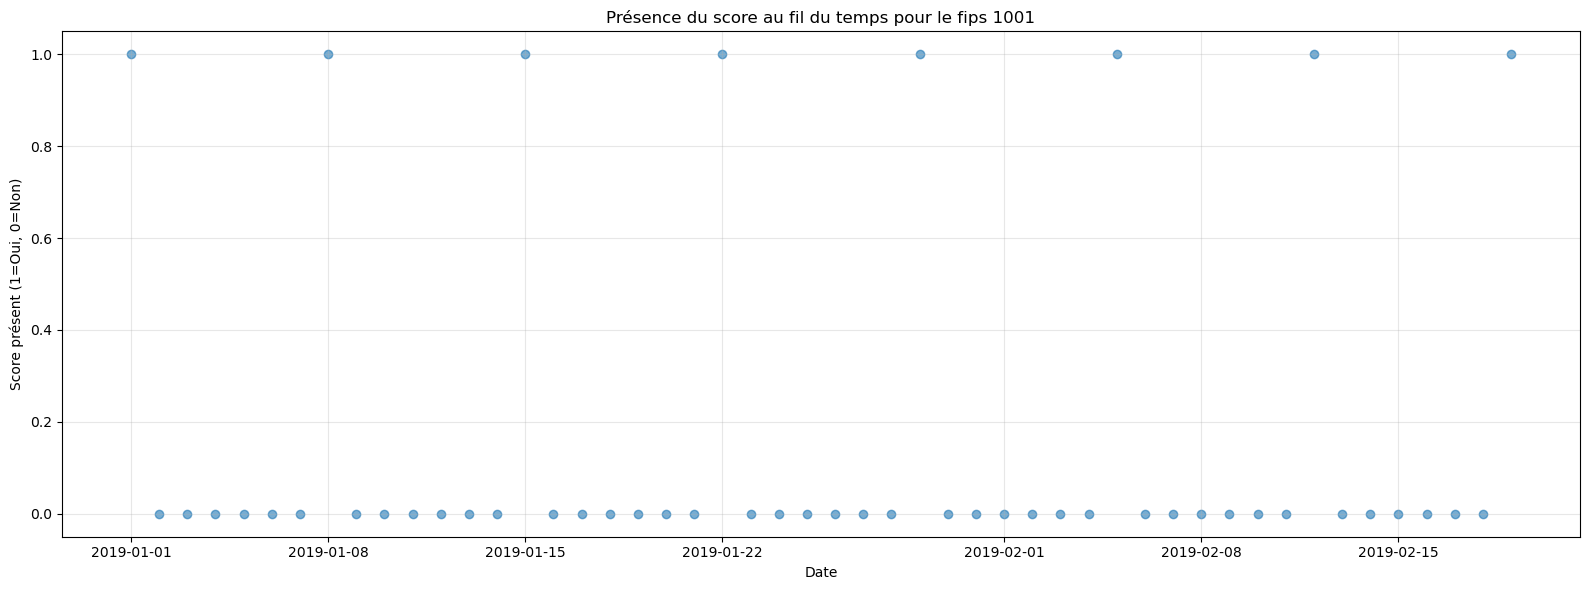

In [ ]:
# Visualisation
fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# Exemple pour un état spécifique
fips_example = X_analysis['fips'].iloc[0]
df_example = X_analysis[X_analysis['fips'] == fips_example].head(50) #exemple avec les 50 premiers jours
axes.scatter(df_example['date'], df_example['score_present'], alpha=0.6)
axes.set_xlabel('Date')
axes.set_ylabel('Score présent (1=Oui, 0=Non)')
axes.set_title(f'Présence du score au fil du temps pour le fips {fips_example}')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("Distribution des intervalles entre mesures du score (en jours):")
print(X_obs["days_diff"].dropna().value_counts().sort_index()) #Distribution du nombre de jours entre deux mesures de score

Distribution des intervalles entre mesures du score (en jours):
days_diff
7.0    323232
Name: count, dtype: int64


On remarque donc que les valeurs manquantes sur la variable cible score proviennent du fait que la mesure effectuée n'est pas journalière mais tous les 7 jours. Or les données de la Nasa sont jounalières. En raison de la suffisance des données qu'on a notre disposition, on décide de les supprimer du dataset.

In [ ]:
X = X[X['score'].notnull()].reset_index(drop=True)

On remarque en plus que les données du score sont continues, on décide de les discrétiser pour créer des classes de score.

In [ ]:
X["score"] = (X["score"]).astype(int)

# Data vizualisation

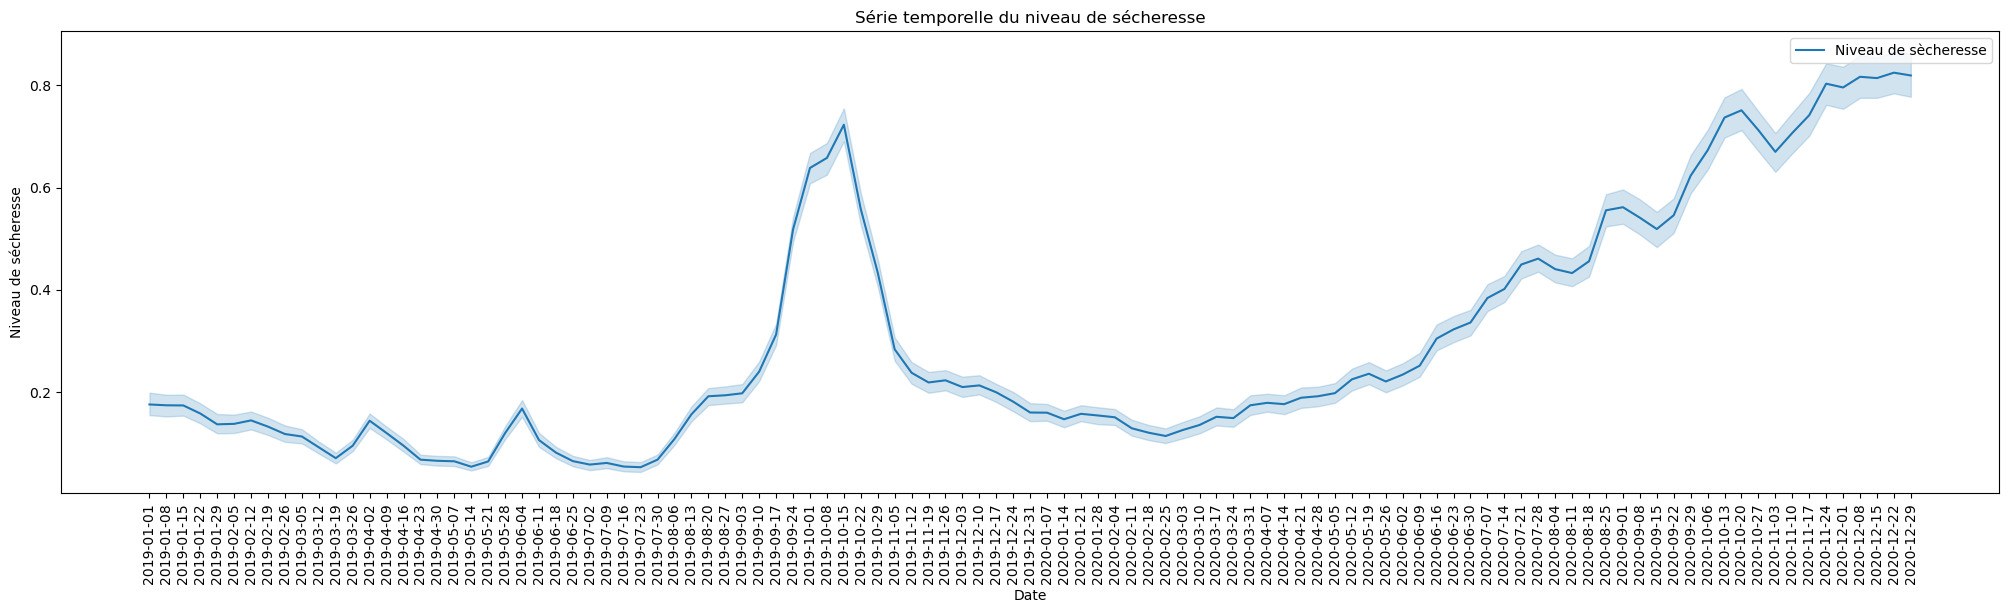

In [ ]:
plt.figure(figsize=(25, 6))
sns.lineplot(x=X['date'], y=X["score"], label='Niveau de sècheresse')
plt.legend()
plt.title('Série temporelle du niveau de sécheresse')
plt.xlabel('Date')
plt.ylabel('Niveau de sécheresse')
plt.xticks(rotation=90)
plt.show()

Le niveau de sécheresse augmente en fonction du temps, ce qui est cohérent avec notre contexte actuel de réchauffement climatique.

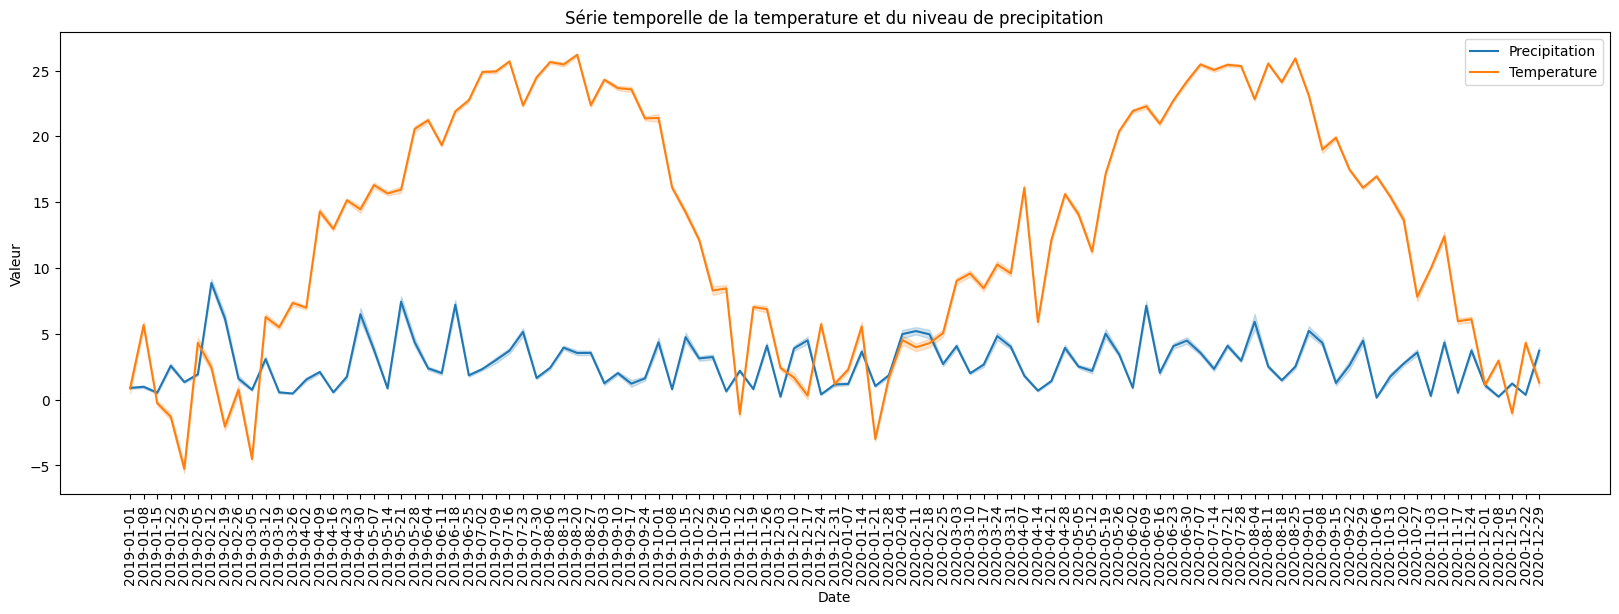

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=X, x='date', y='PRECTOT', label='Precipitation')
sns.lineplot(data=X, x='date', y='T2M', label='Temperature')
plt.title('Série temporelle de la temperature et du niveau de precipitation')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.xticks(rotation=90)
plt.show()

On identifie le cylce saisonnier des températures.

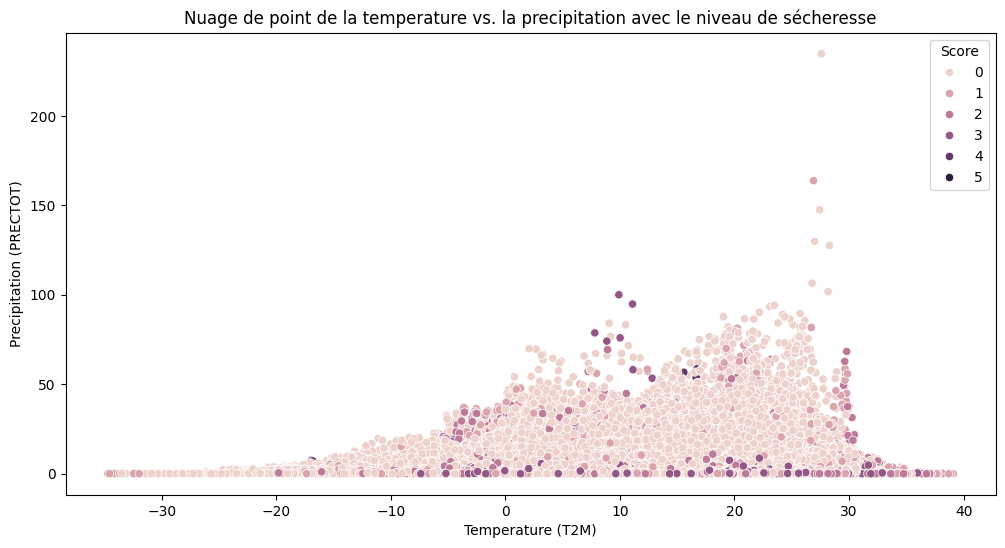

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=X, x='T2M', y='PRECTOT', hue=X["score"])
plt.title("Nuage de point de la temperature vs. la precipitation avec le niveau de sécheresse")
plt.xlabel('Temperature (T2M)')
plt.ylabel('Precipitation (PRECTOT)')
plt.legend(title='Score')
plt.show()

#Statistiques déscriptives

In [ ]:
display(X.describe().T) #Pour les variables numériques
display(X.describe(include=['object'])) #Pour les variables catégorielles

count          mean           std          min  \
fips           326340.0  30670.376770  14979.130338  1001.000000   
PRECTOT        326340.0      2.773609      6.271320     0.000000   
PS             326340.0     96.664013      5.439992    66.930000   
QV2M           326340.0      8.193530      4.956830     0.150000   
T2M            326340.0     12.809354     10.990227   -34.690000   
T2MDEW         326340.0      7.637028     10.524875   -37.840000   
T2MWET         326340.0      7.681143     10.260454   -34.830000   
T2M_MAX        326340.0     18.447932     11.575784   -28.350000   
T2M_MIN        326340.0      7.651906     10.755246   -41.960000   
T2M_RANGE      326340.0     10.796031      3.835380     0.120000   
TS             326340.0     12.848721     11.180749   -35.770000   
WS10M          326340.0      3.503870      1.774304     0.400000   
WS10M_MAX      326340.0      5.135148      2.542583     0.710000   
WS10M_MIN      326340.0      1.874162      1.275018     0.000000   
WS10M_RANGE    326340.0      3.260994      1.934575     0.260000   
WS50M          326340.0      5.454730      2.204150     0.700000   
WS50M_MAX      326340.0      7.736035      2.747975     1.270000   
WS50M_MIN      326340.0      3.049395      2.024862     0.000000   
WS50M_RANGE    326340.0      4.686642      2.163710     0.530000   
score          326340.0      0.297156      0.721083     0.000000   
lat            326340.0     38.278261      4.837610    25.601043   
lon            326340.0    -91.655636     11.482973  -124.211407   
elevation      326340.0    427.351673    499.928014    -1.000000   
slope1         326340.0      0.054986      0.089870     0.000000   
slope2         326340.0      0.297783      0.215943     0.000000   
slope3         326340.0      0.319896      0.167643     0.000000   
slope4         326340.0      0.155874      0.128400     0.000000   
slope5         326340.0      0.053425      0.073101     0.000000   
slope6         326340.0      0.065344      0.125521     0.000000   
slope7         326340.0      0.022230      0.064126     0.000000   
slope8         326340.0      0.009270      0.044933     0.000000   
aspectN        326340.0      0.143746      0.078237     0.000000   
aspectE        326340.0      0.168858      0.084088     0.000000   
aspectS        326340.0      0.148378      0.082108     0.000000   
aspectW        326340.0      0.165056      0.087842     0.000000   
aspectUnknown  326340.0      0.352769      0.272171     0.000000   
WAT_LAND       326340.0      2.851428     13.159168     0.000000   
NVG_LAND       326340.0      1.799070      7.970712     0.000000   
URB_LAND       326340.0      2.670885      9.770591     0.000000   
GRS_LAND       326340.0     19.789316     25.415592     0.000000   
FOR_LAND       326340.0     39.309230     34.358350     0.000000   
CULTRF_LAND    326340.0     28.503972     31.835447     0.000000   
CULTIR_LAND    326340.0      3.505807     10.290717     0.000000   
CULT_LAND      326340.0     32.009779     33.094731     0.000000   
SQ1            326340.0      1.830759      1.192128     0.000000   
SQ2            326340.0      1.553732      1.021336     0.000000   
SQ3            326340.0      1.281853      1.002427     0.000000   
SQ4            326340.0      1.357465      1.030092     0.000000   
SQ5            326340.0      1.147040      0.922305     0.000000   
SQ6            326340.0      1.135135      0.914500     0.000000   
SQ7            326340.0      1.284749      1.017385     0.000000   

                        25%           50%           75%           max  
fips           19044.500000  29212.000000  46007.500000  56043.000000  
PRECTOT            0.000000      0.200000      2.540000    234.800000  
PS                95.860000     98.310000     99.970000    103.790000  
QV2M               3.910000      7.050000     12.190000     21.800000  
T2M                4.380000     13.950000     22.070000     39.110000  
T2MDEW            -0.360000      8.200000     16.

date
count       326340
unique         105
top     2019-01-01
freq          3108

L'unique variable non numérique qu'on aperçoit dans notre base de données, on va donc la retraiter.

In [ ]:
def Split_Date(df):
  df['date'] = pd.to_datetime(df['date'])
  df['day'] = df['date'].dt.day
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  return df

In [ ]:
X["date"]

0         2019-01-01
1         2019-01-08
2         2019-01-15
3         2019-01-22
4         2019-01-29
             ...    
326335    2020-12-01
326336    2020-12-08
326337    2020-12-15
326338    2020-12-22
326339    2020-12-29
Name: date, Length: 326340, dtype: object

In [ ]:
X = Split_Date(X)

In [ ]:
X = X.drop(['date'], axis =1) #Pour éviter la redondance

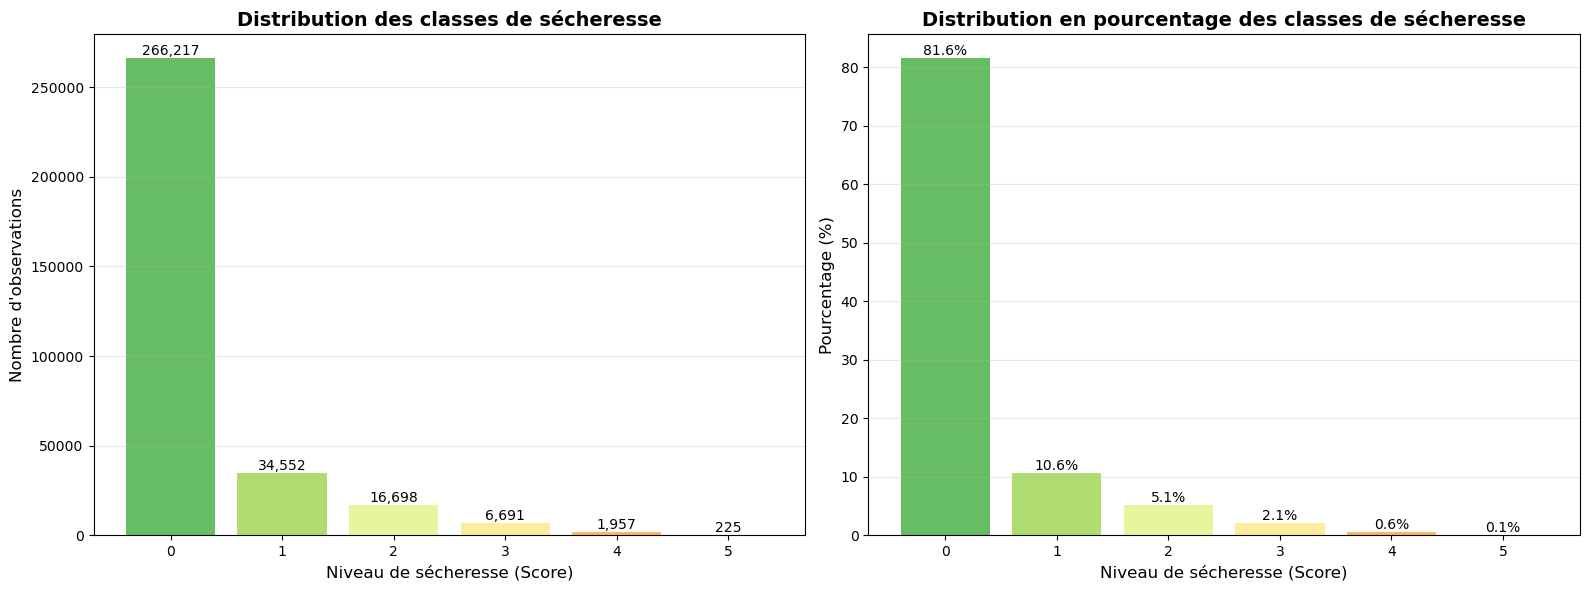

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Comptage par classe
score_counts = X['score'].value_counts().sort_index()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(score_counts)))

axes[0].bar(score_counts.index, score_counts.values, color=colors)
axes[0].set_xlabel('Niveau de sécheresse (Score)', fontsize=12)
axes[0].set_ylabel('Nombre d\'observations', fontsize=12)
axes[0].set_title('Distribution des classes de sécheresse', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (idx, val) in enumerate(score_counts.items()):
    axes[0].text(idx, val, f'{val:,}', ha='center', va='bottom', fontsize=10)

# Graphique 2: Pourcentages
score_percentages = (X['score'].value_counts(normalize=True).sort_index() * 100)
axes[1].bar(score_percentages.index, score_percentages.values, color=colors)
axes[1].set_xlabel('Niveau de sécheresse (Score)', fontsize=12)
axes[1].set_ylabel('Pourcentage (%)', fontsize=12)
axes[1].set_title('Distribution en pourcentage des classes de sécheresse', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Ajouter les pourcentages sur les barres
for i, (idx, val) in enumerate(score_percentages.items()):
    axes[1].text(idx, val, f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout() # Ajuster l'espacement
plt.show()


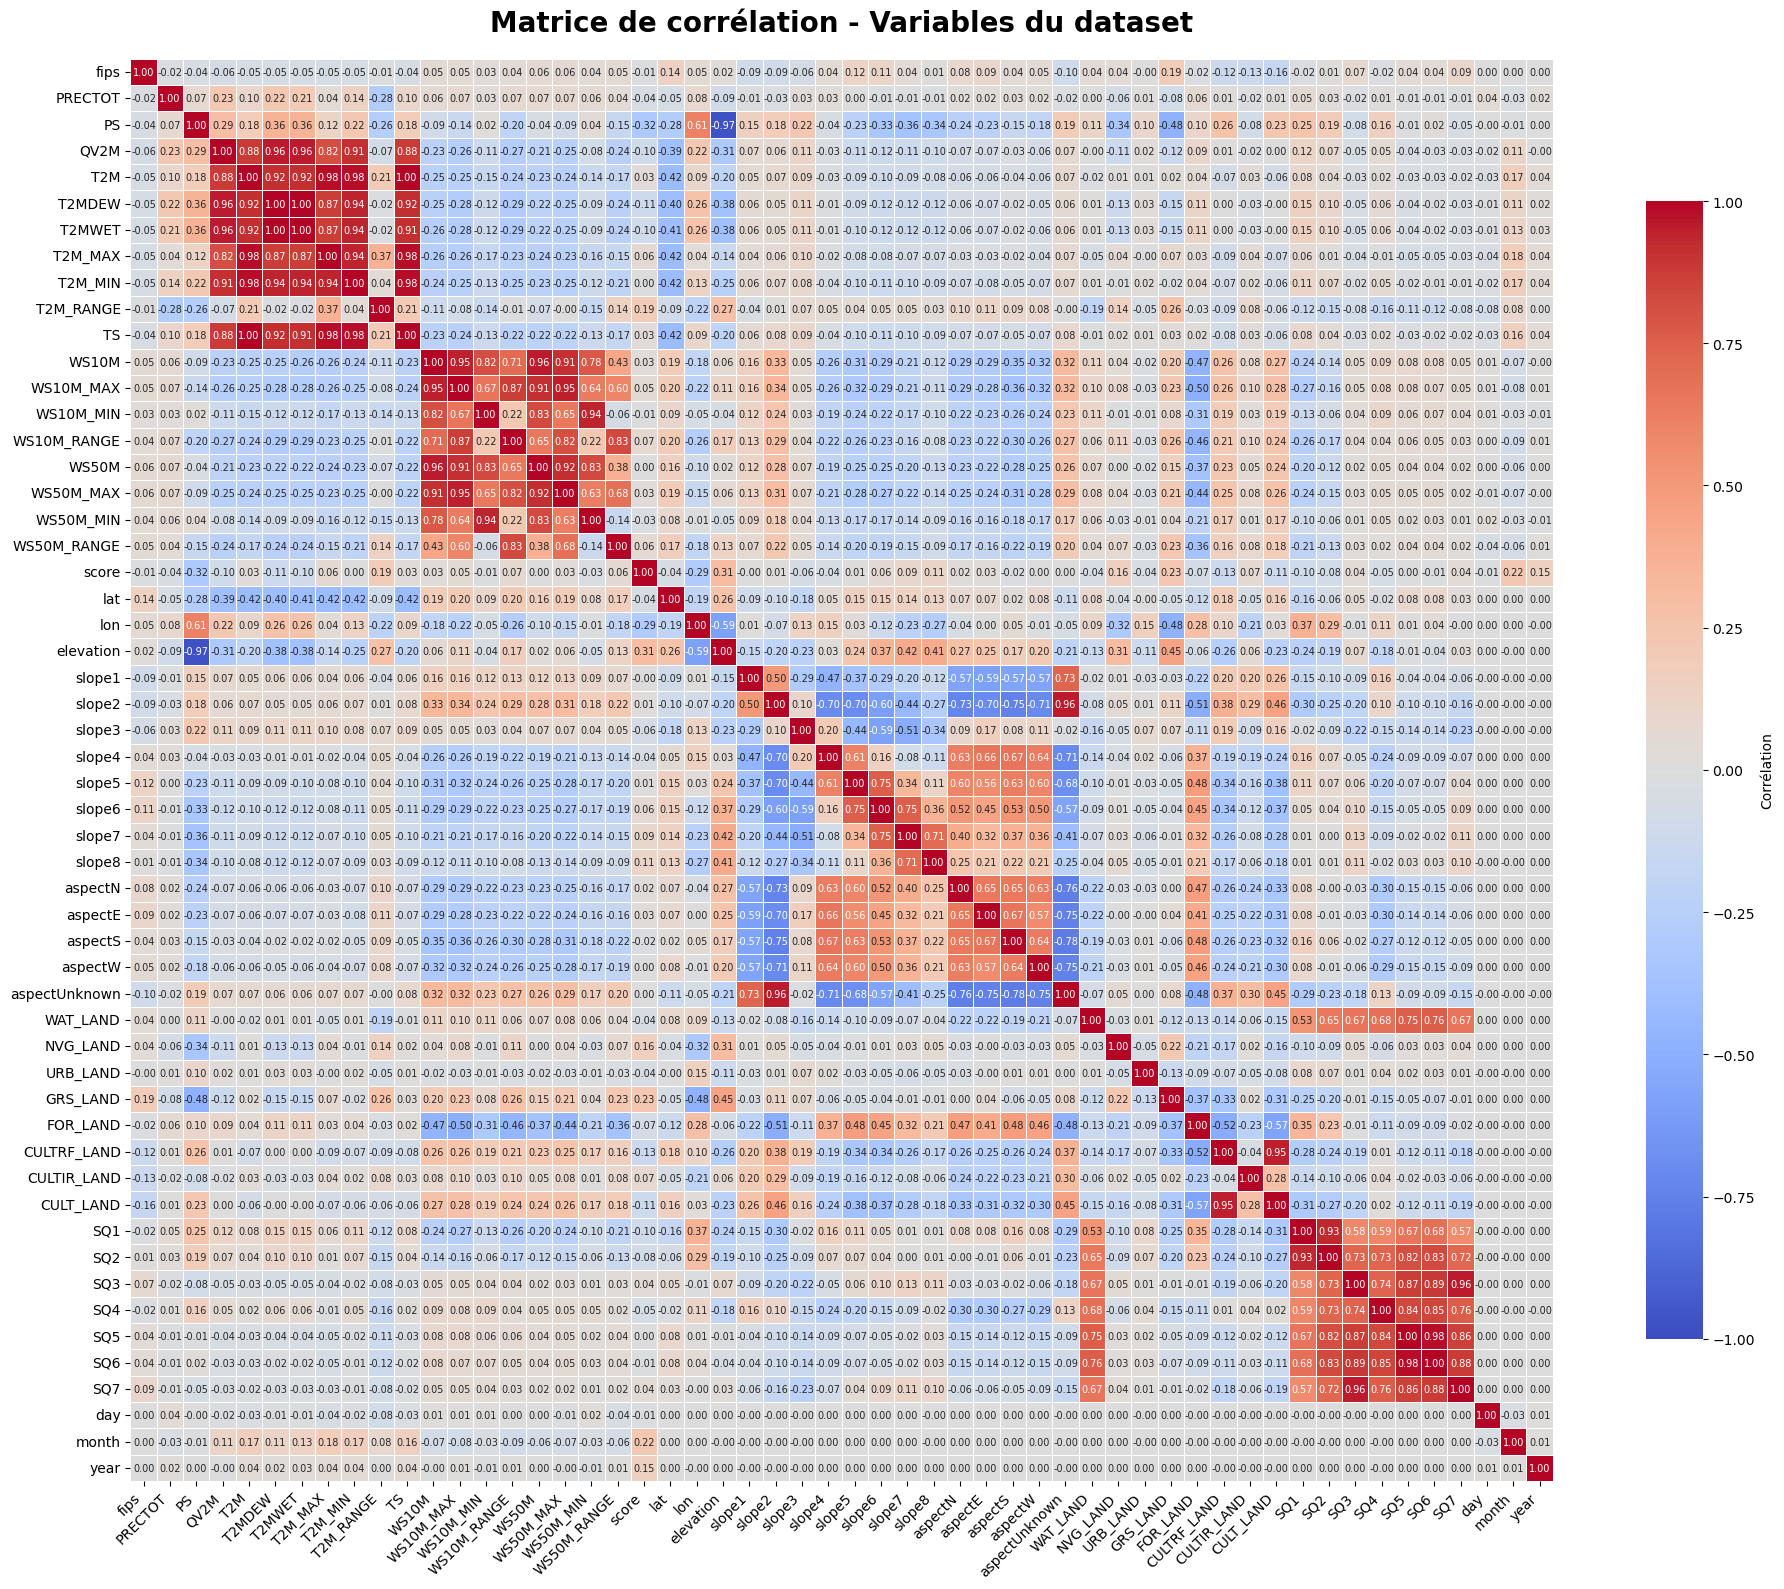

In [ ]:
correlation_matrix = X.corr().round(2)

plt.figure(figsize=(20, 16)) # On crée une figure avec une taille appropriée
sns.heatmap(data=correlation_matrix,
            annot=True,                          # Pour afficher les valeurs
            fmt='.2f',                           # Format avec 2 décimales
            annot_kws={"size": 7},              # Taille de police des valeurs
            cmap='coolwarm',                     # Palette de couleurs (rouge-bleu)
            center=0,                            # Centrer la palette sur 0
            vmin=-1, vmax=1,                    # Échelle de -1 à 1
            square=True,                         # Cellules carrées
            linewidths=0.5,                     # Lignes entre cellules
            linecolor='white',                   # Couleur des lignes
            cbar_kws={'shrink': 0.8, 'label': 'Corrélation'})  # Barre de couleur

plt.title("Matrice de corrélation - Variables du dataset", fontsize=20, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)


plt.tight_layout()
plt.show()

On remarque que les variables sur la vitesse du vent et la température sont très corrélées.

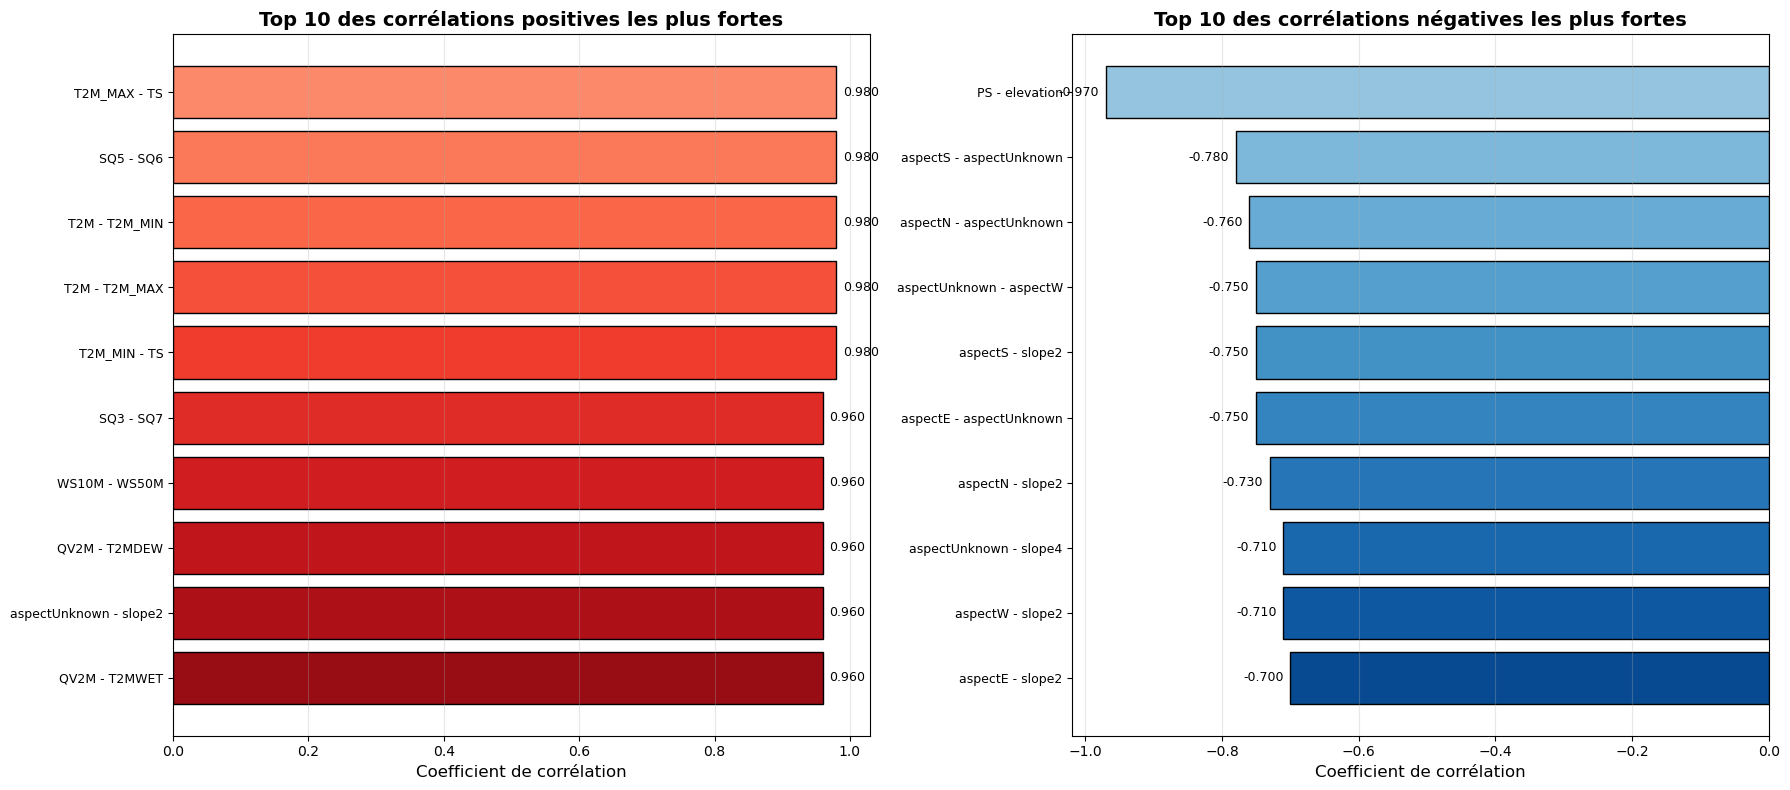

In [ ]:
corr_pairs = correlation_matrix.unstack() # Créer un DataFrame avec les corrélations
corr_pairs = corr_pairs[corr_pairs < 1]  # Exclure la diagonale (corrélation = 1)

corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1)]

positive_corr = corr_pairs[corr_pairs > 0].sort_values(ascending=False)
negative_corr = corr_pairs[corr_pairs < 0].sort_values(ascending=True)

top_positive = positive_corr.head(10)
top_negative = negative_corr.head(10)

def create_labels(series):
    labels = []
    for idx in series.index:
        labels.append(f"{idx[0]} - {idx[1]}")
    return labels

# Créer la figure avec 2 sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Graphique 1: Top 10 corrélations positives
colors_pos = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_positive)))
axes[0].barh(range(len(top_positive)), top_positive.values, color=colors_pos, edgecolor='black')
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(create_labels(top_positive), fontsize=9)
axes[0].set_xlabel('Coefficient de corrélation', fontsize=12)
axes[0].set_title('Top 10 des corrélations positives les plus fortes', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Ajouter les valeurs sur les barres
for i, v in enumerate(top_positive.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Graphique 2: Top 10 corrélations négatives (les plus fortes en valeur absolue)
colors_neg = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_negative)))
axes[1].barh(range(len(top_negative)), top_negative.values, color=colors_neg, edgecolor='black')
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(create_labels(top_negative), fontsize=9)
axes[1].set_xlabel('Coefficient de corrélation', fontsize=12)
axes[1].set_title('Top 10 des corrélations négatives les plus fortes', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# Ajouter les valeurs sur les barres
for i, v in enumerate(top_negative.values):
    axes[1].text(v - 0.01, i, f'{v:.3f}', va='center', ha='right', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Afficher aussi le tableau sous forme textuelle
print("\n" + "="*70)
print("TOP 10 DES CORRÉLATIONS POSITIVES LES PLUS FORTES")
print("="*70)
for (var1, var2), corr in top_positive.items():
    print(f"{var1:20s} <-> {var2:20s} : {corr:6.3f}")

print("\n" + "="*70)
print("TOP 10 DES CORRÉLATIONS NÉGATIVES LES PLUS FORTES")
print("="*70)
for (var1, var2), corr in top_negative.items():
    print(f"{var1:20s} <-> {var2:20s} : {corr:6.3f}")


TOP 10 DES CORRÉLATIONS POSITIVES LES PLUS FORTES
SQ5                  <-> SQ6                  :  0.980
T2M                  <-> T2M_MIN              :  0.980
T2M                  <-> T2M_MAX              :  0.980
T2M_MAX              <-> TS                   :  0.980
T2M_MIN              <-> TS                   :  0.980
QV2M                 <-> T2MWET               :  0.960
QV2M                 <-> T2MDEW               :  0.960
SQ3                  <-> SQ7                  :  0.960
WS10M                <-> WS50M                :  0.960
aspectUnknown        <-> slope2               :  0.960

TOP 10 DES CORRÉLATIONS NÉGATIVES LES PLUS FORTES
PS                   <-> elevation            : -0.970
aspectS              <-> aspectUnknown        : -0.780
aspectN              <-> aspectUnknown        : -0.760
aspectS              <-> slope2               : -0.750
aspectE              <-> aspectUnknown        : -0.750
aspectUnknown        <-> aspectW              : -0.750
aspectN           

On s'intéresse à présent aux corrélations linéaires les plus fortes avec la variable cible "score".

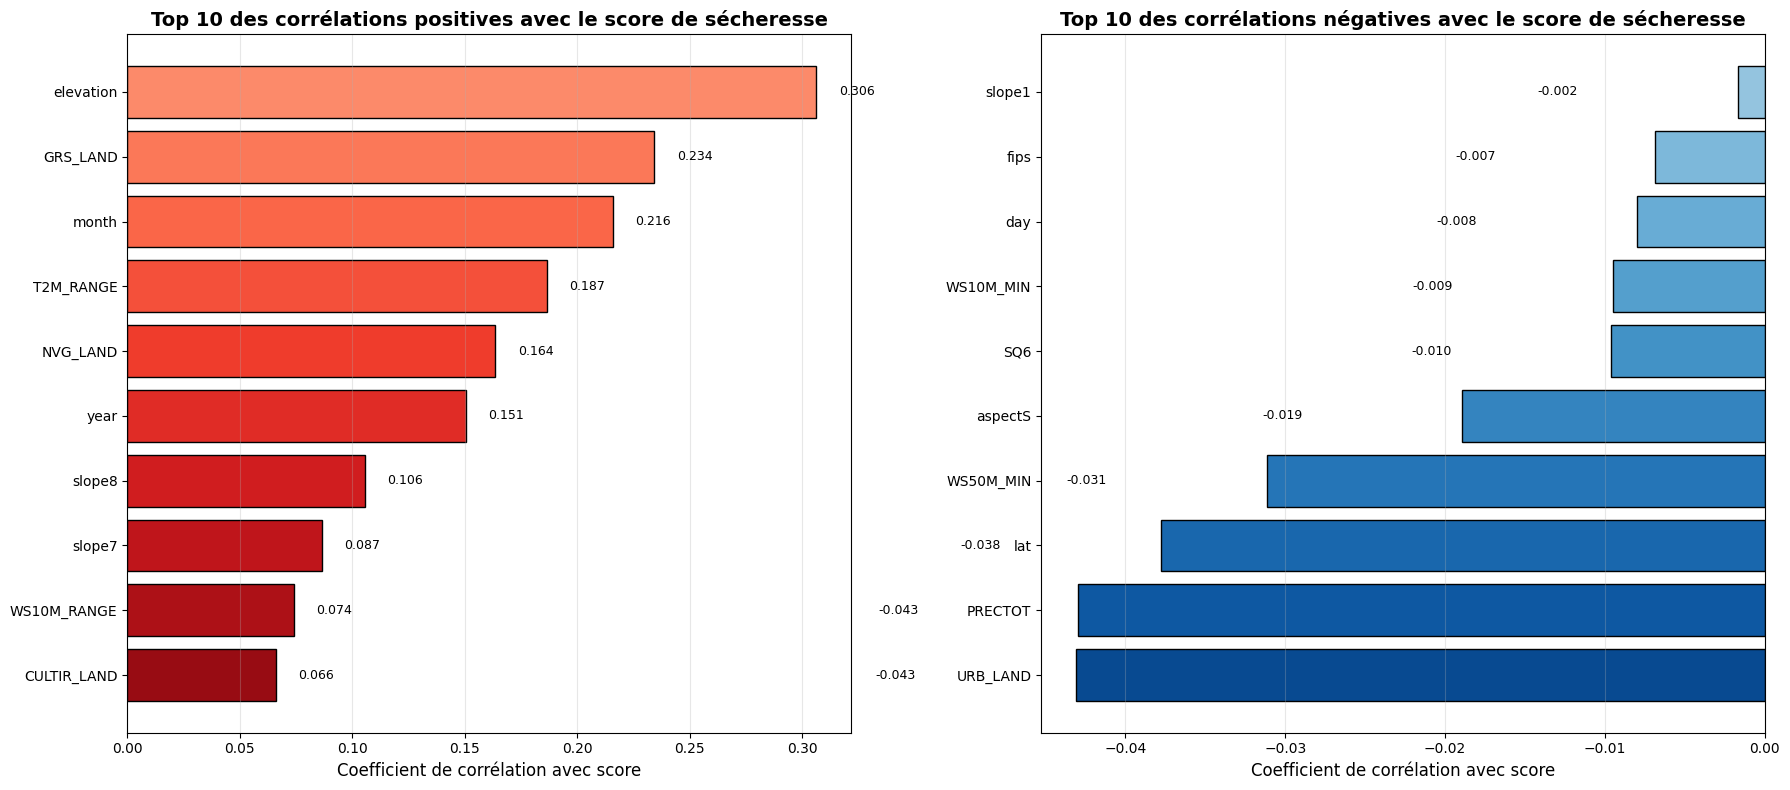

In [ ]:
# Calculer les corrélations avec la variable score
correlations_with_score = X.corr()['score'].drop('score').sort_values(ascending=False)

positive_corr_score = correlations_with_score[correlations_with_score > 0].head(10)
negative_corr_score = correlations_with_score[correlations_with_score < 0].head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Graphique 1: Top 10 corrélations positives avec score
colors_pos = plt.cm.Reds(np.linspace(0.4, 0.9, len(positive_corr_score)))
axes[0].barh(range(len(positive_corr_score)), positive_corr_score.values, color=colors_pos, edgecolor='black')
axes[0].set_yticks(range(len(positive_corr_score)))
axes[0].set_yticklabels(positive_corr_score.index, fontsize=10)
axes[0].set_xlabel('Coefficient de corrélation avec score', fontsize=12)
axes[0].set_title('Top 10 des corrélations positives avec le score de sécheresse', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Ajouter les valeurs sur les barres
for i, v in enumerate(positive_corr_score.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Graphique 2: Top 10 corrélations négatives avec score
colors_neg = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_corr_score)))
axes[1].barh(range(len(negative_corr_score)), negative_corr_score.values, color=colors_neg, edgecolor='black')
axes[1].set_yticks(range(len(negative_corr_score)))
axes[1].set_yticklabels(negative_corr_score.index, fontsize=10)
axes[1].set_xlabel('Coefficient de corrélation avec score', fontsize=12)
axes[1].set_title('Top 10 des corrélations négatives avec le score de sécheresse', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# Ajouter les valeurs sur les barres
for i, v in enumerate(negative_corr_score.values):
    axes[1].text(v - 0.01, i, f'{v:.3f}', va='center', ha='right', fontsize=9)

plt.tight_layout()
plt.show()

La variable sur l'elevation du sol est la variable la plus corrélée avec le score. Ce graphique nous donne une idée des variables corrélées linéairement au score. Cependant, on ne peut pas choisir des variables en fonction de cette métrique car il peut y avoir des dépendances non linéaires.

On s'intéresse à présent à la distribution des variables explicatives.

In [ ]:
var_num = [x for x in X.select_dtypes(include=["int64", "float64", "int32"])]
var_cat = ["fips", "score", "year", "month", "day",'SQ1','SQ2','SQ3','SQ4','SQ5','SQ6','SQ7'] #variables non cotinues
var_num = [i for i in var_num if i not in var_cat]
X_num = X[var_num]

## Distribution des variables continues

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


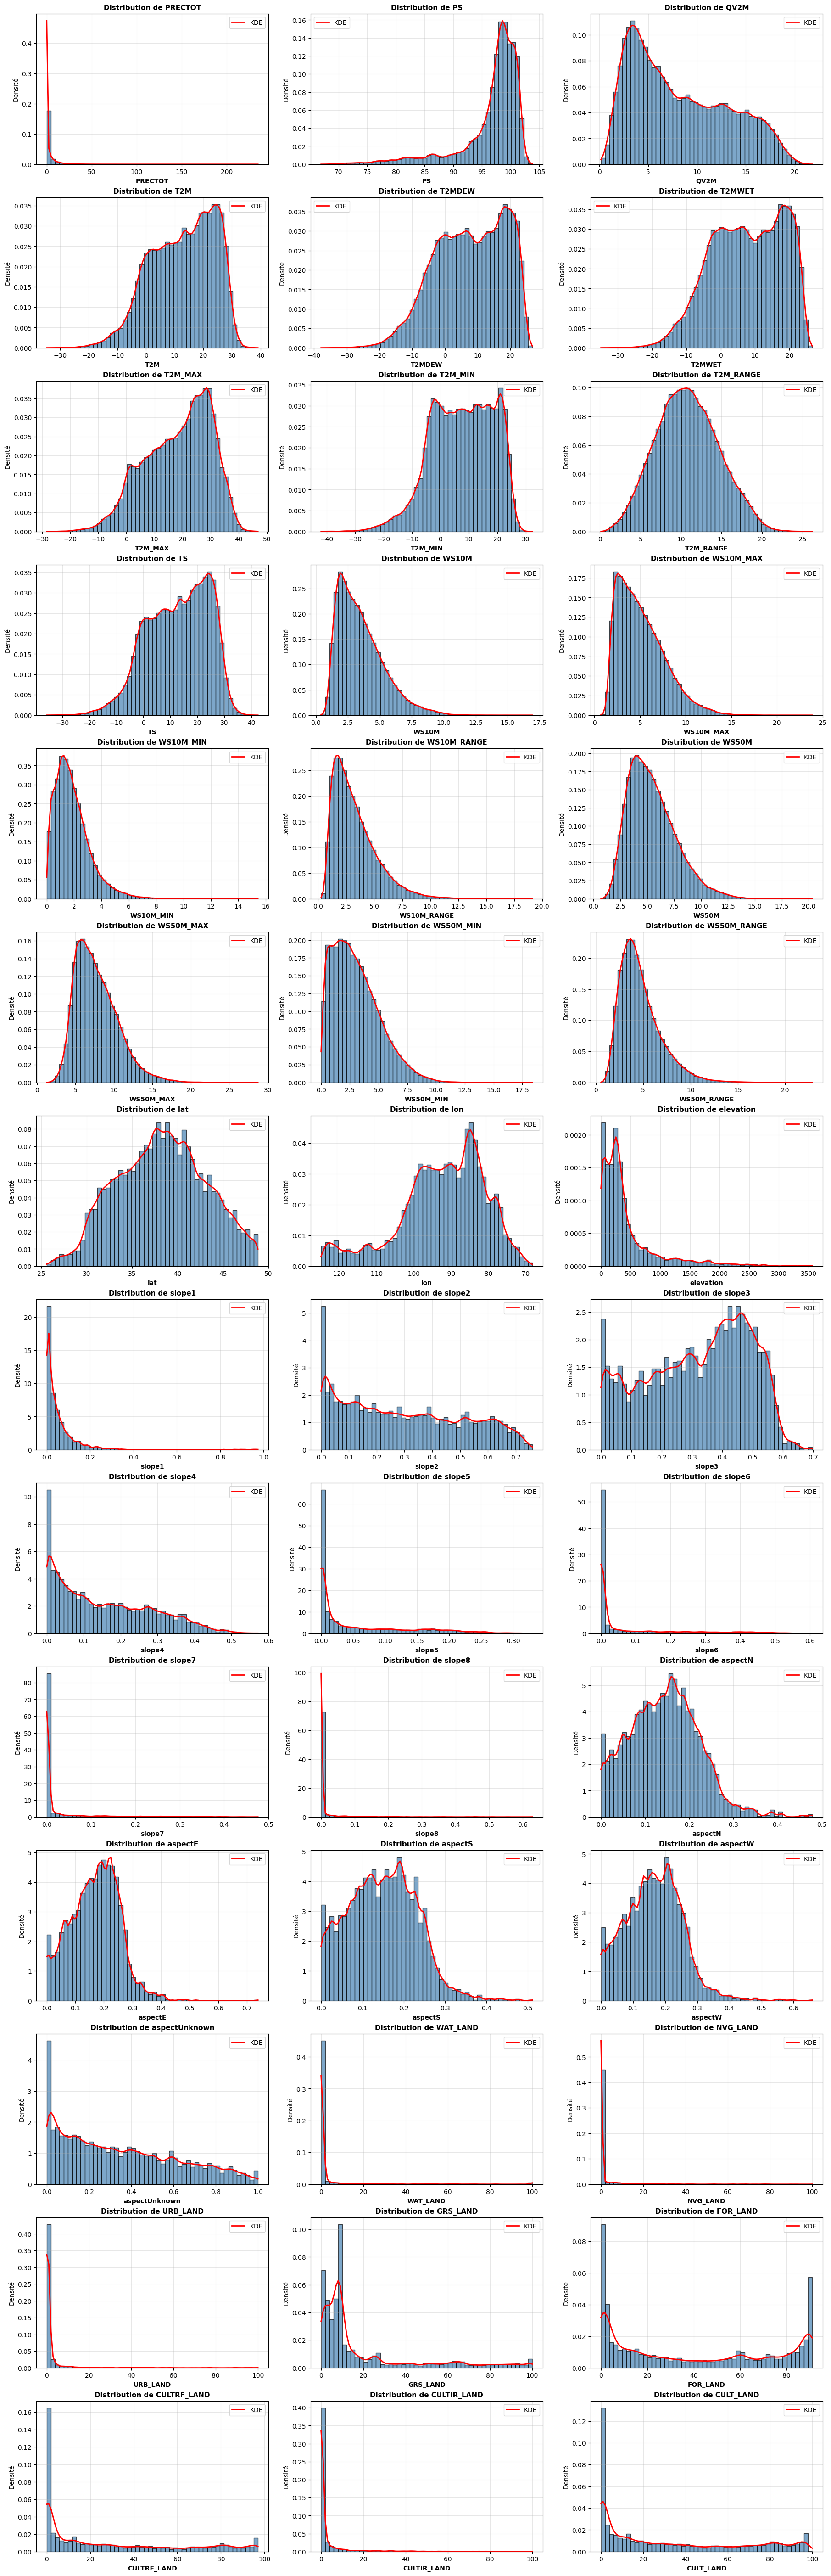

In [ ]:
from scipy.stats import gaussian_kde

num_cols = 3  # Nombre d'histogrammes par ligne
num_rows = (len(var_num) + num_cols - 1) // num_cols  # Nombre de lignes dont nous avons besoin

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4), constrained_layout=True)
axes = axes.flatten()  # Pour améliorer les itérations

for i, col_name in enumerate(var_num):
    ax = axes[i]
    ax.hist(X_num[col_name], bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')

    # On vérifie si la variable est continue (plus de 20 valeurs uniques)
    n_unique = X_num[col_name].nunique()

    # On ajoute une ligne de densité (KDE) uniquement pour les variables continues
    if n_unique > 20:
        try:
            kde = gaussian_kde(X_num[col_name].dropna())
            x_range = np.linspace(X_num[col_name].min(), X_num[col_name].max(), 100)
            ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
            ax.legend()
        except:
            pass

    ax.set_xlabel(col_name, fontsize=10, fontweight='bold')
    ax.set_ylabel('Densité', fontsize=10)
    ax.set_title(f'Distribution de {col_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# On masque les axes vides si le nombre de variables n'est pas un multiple de num_cols
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

##Distributions des variables non continues

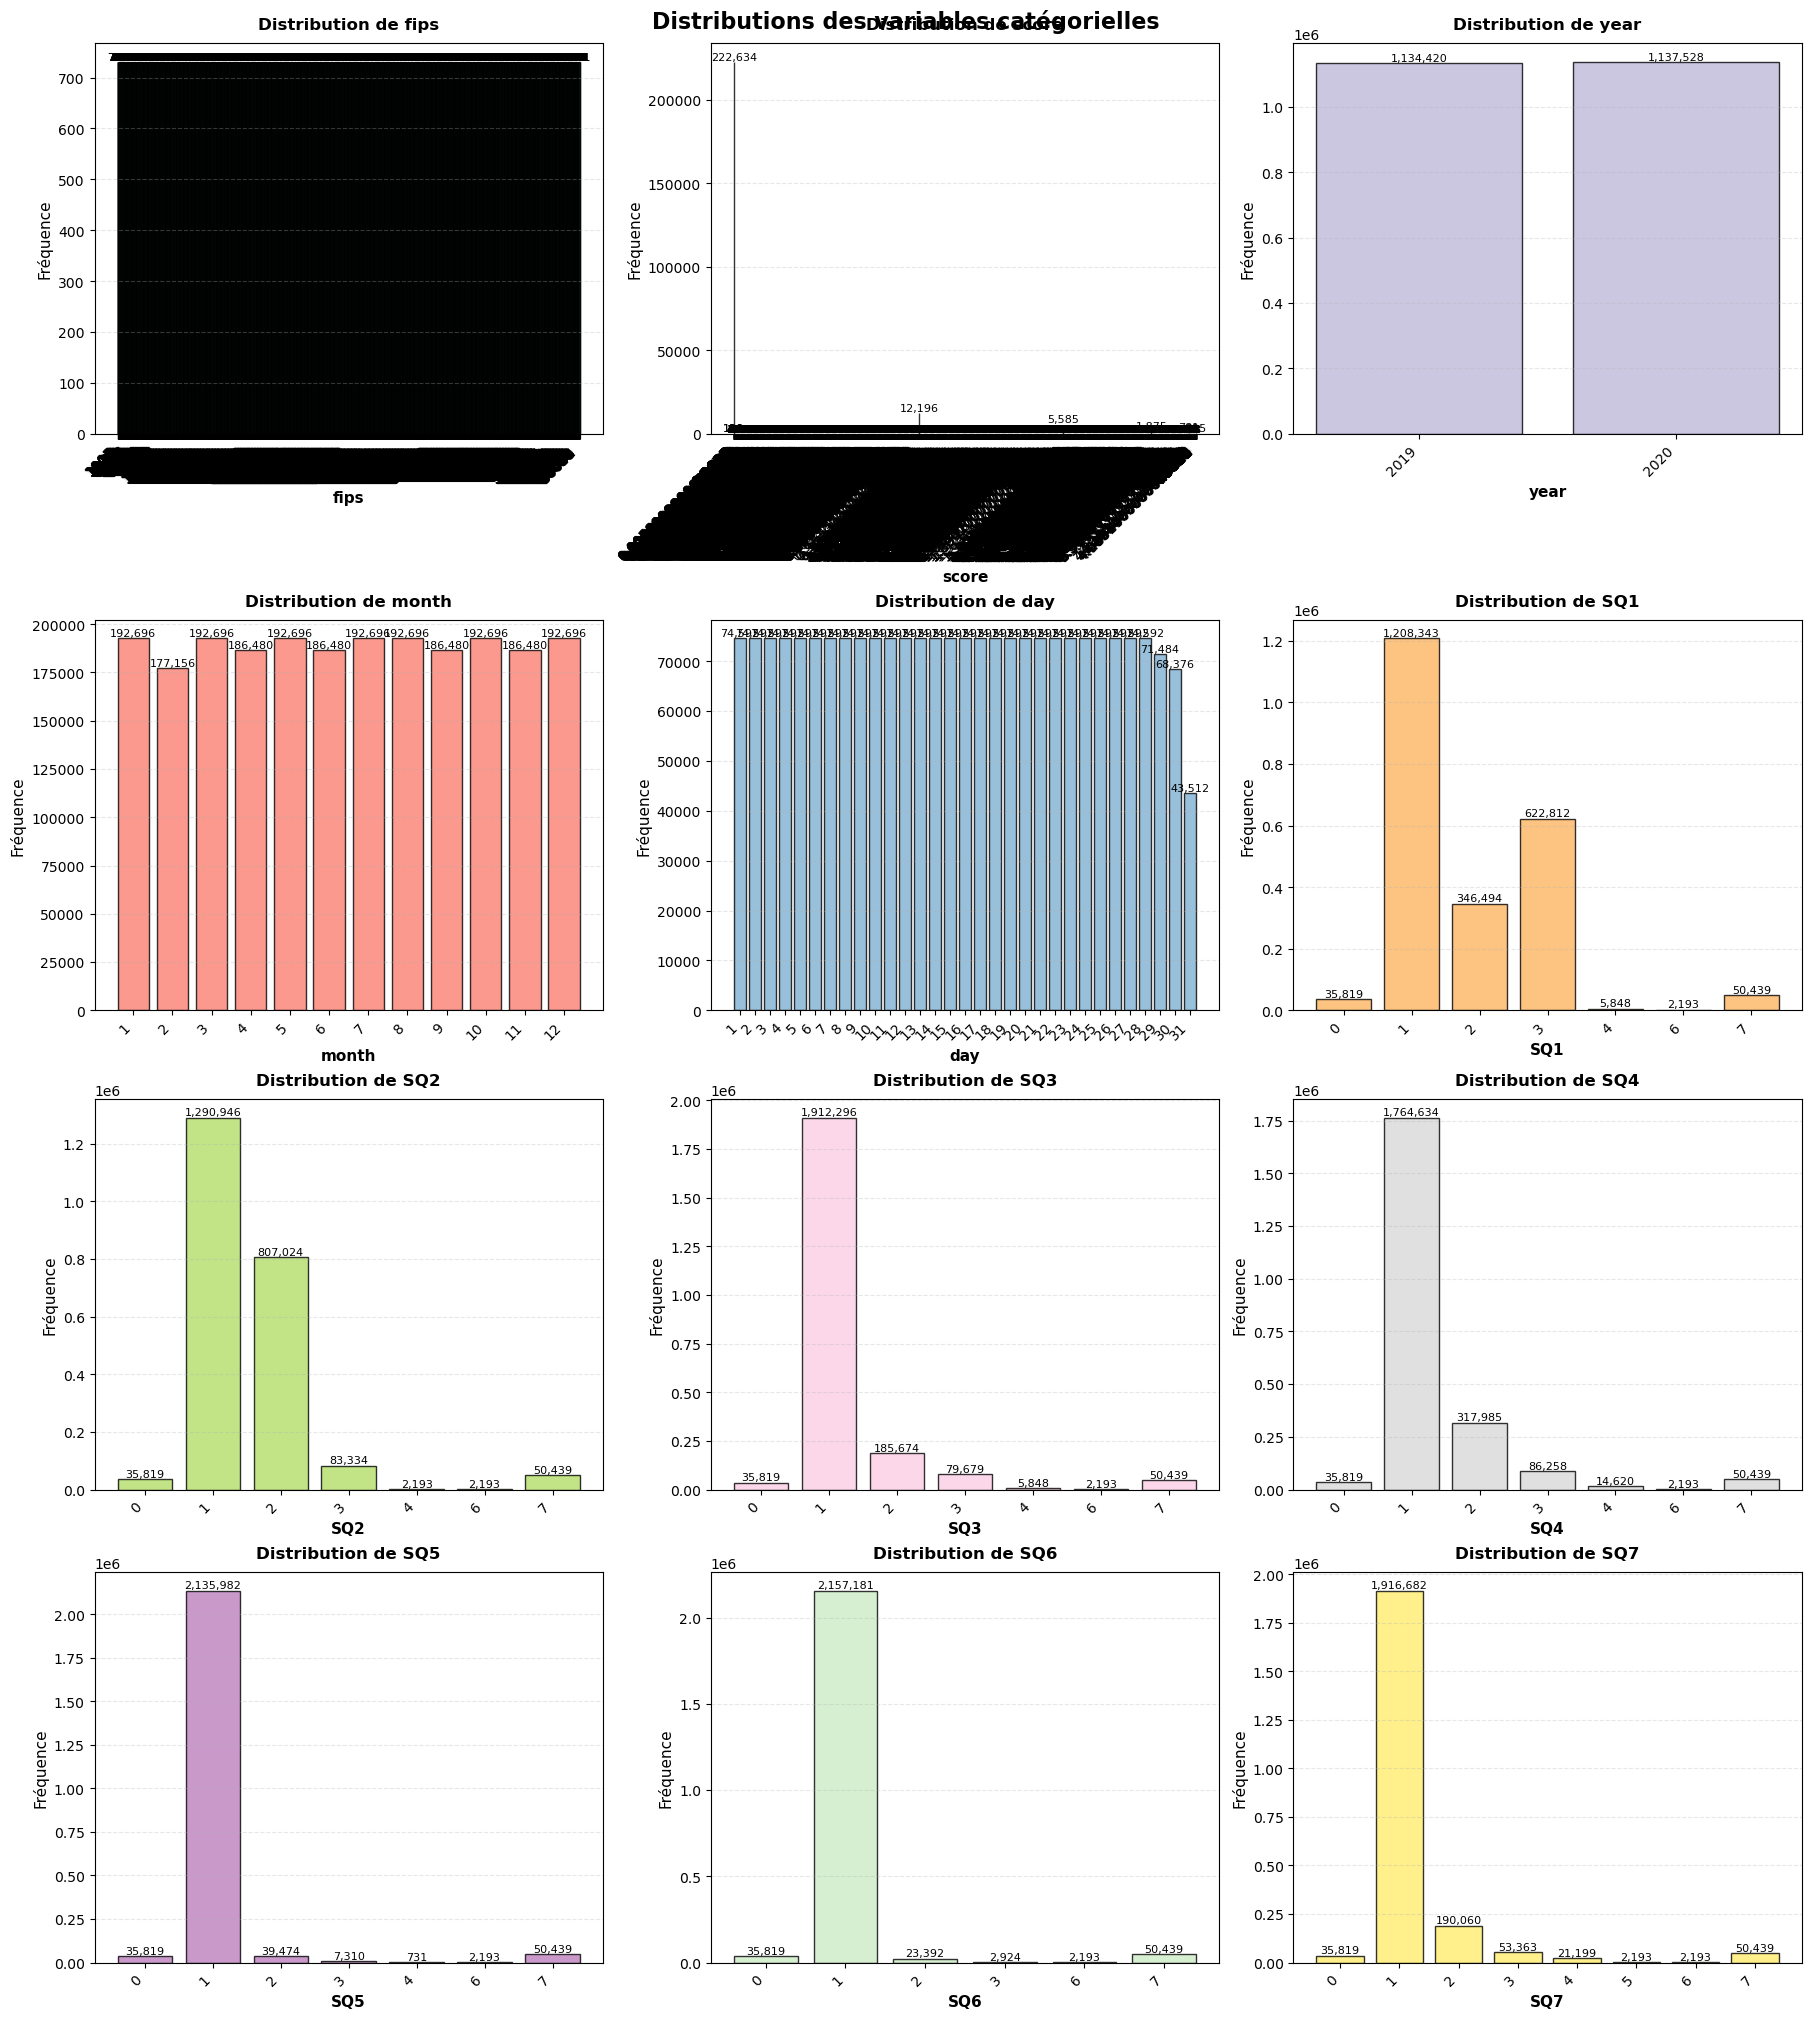

In [ ]:
X_cat = X[var_cat]
n_vars = len(var_cat)
num_cols = 3  # Nombre de graphiques par ligne
num_rows = (n_vars + num_cols - 1) // num_cols  # Nombre de lignes nécessaires

# On crée la figure avec des subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5), constrained_layout=True)
axes = axes.flatten()  # Aplatir pour faciliter l'itération

# Palette de couleurs
colors = plt.cm.Set3(np.linspace(0, 1, 12))

for i, col_name in enumerate(var_cat):
    ax = axes[i]

    # On compte les valeurs et on les trie
    value_counts = X_cat[col_name].value_counts().sort_index()

    # On crée le graphique en barres
    bars = ax.bar(range(len(value_counts)), value_counts.values,
                   color=colors[i % len(colors)],
                   edgecolor='black',
                   alpha=0.8)

    # Personnalisation les axes
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_xlabel(col_name, fontsize=11, fontweight='bold')
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title(f'Distribution de {col_name}', fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Ajout des valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=8)

# On masque les axes vides
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distributions des variables catégorielles', fontsize=16, fontweight='bold', y=1.002)
plt.show()

##Feature selection : Variabilité des caractéristiques

On mesure la variance des variables car cela nous donne une idée des variables qui n'apportent aucun pouvoir explicatif au modèle (les variables à faible variance).

In [ ]:
# Sélectionner uniquement les variables quantitatives (en excluant 'score' et 'fips')
quanti = [elem for elem in X.describe().columns if (elem != 'score')]
var_supp = []

# Calculer la variance de chaque variable
variances = X[quanti].var().sort_values(ascending=False)

print("Variance de chaque variable (triées par ordre décroissant) :")
print("-" * 70)
for var_name, var_value in variances.items():
    print(f"{var_name:30s} : {var_value:>15.4f}")

# Définir un seuil de variance minimale
threshold = 0.01

print(f"\n{'='*70}")
print(f"SEUIL DE VARIANCE DÉFINI : {threshold}")
print("="*70)

# Identifier les variables à faible variance
low_variance_vars = variances[variances < threshold]

if len(low_variance_vars) > 0:
    print(f"\n Variables avec variance < {threshold} (à supprimer) :")
    print("-" * 70)
    for var_name, var_value in low_variance_vars.items():
        print(f"{var_name:30s} : {var_value:>15.6f}")
        var_supp.append(var_name) #On supprime les variables à faible variance

else:
    print(f"\n✓ Aucune variable avec variance < {threshold}")

# Conserver uniquement les variables avec variance suffisante
quanti_filtered = [var for var in quanti if variances[var] >= threshold]

print(f"\n{'='*70}")
print(f"RÉSULTAT DE LA SÉLECTION")
print("="*70)
print(f"Variables conservées : {len(quanti_filtered)} / {len(quanti)}")
print(f"Variables supprimées : {len(quanti) - len(quanti_filtered)}")

Variance de chaque variable (triées par ordre décroissant) :
----------------------------------------------------------------------
fips                           :  224374345.6861
elevation                      :     249928.0196
FOR_LAND                       :       1180.4962
CULT_LAND                      :       1095.2613
CULTRF_LAND                    :       1013.4957
GRS_LAND                       :        645.9523
WAT_LAND                       :        173.1637
T2M_MAX                        :        133.9988
lon                            :        131.8587
TS                             :        125.0091
T2M                            :        120.7851
T2M_MIN                        :        115.6753
T2MDEW                         :        110.7730
CULTIR_LAND                    :        105.8989
T2MWET                         :        105.2769
URB_LAND                       :         95.4644
day                            :         78.3482
NVG_LAND                       :   

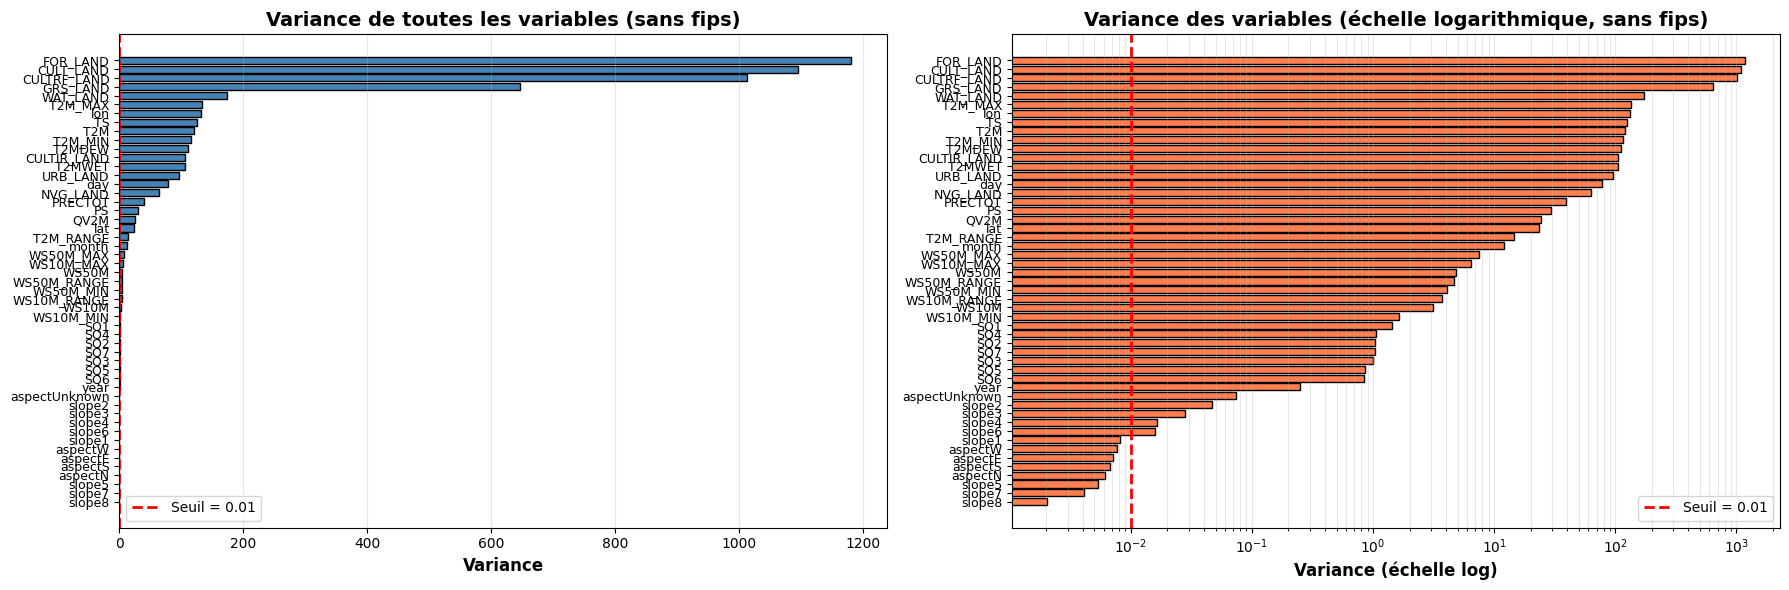

In [ ]:
# Visualisation des variances
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

quanti_ = [elem for elem in X.describe().columns if (elem != 'score')and (elem != 'fips')and (elem != 'elevation')] #Je change car fips et elevation ont une variance énorme par rapport aux autres
variances = X[quanti_].var().sort_values(ascending=False)

# Graphique 1: Toutes les variances
axes[0].barh(range(len(variances)), variances.values, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(variances)))
axes[0].set_yticklabels(variances.index, fontsize=9)
axes[0].set_xlabel('Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Variance de toutes les variables (sans fips)', fontsize=14, fontweight='bold')
axes[0].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Seuil = {threshold}')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Graphique 2: Variances en échelle logarithmique (pour mieux voir les petites valeurs)
axes[1].barh(range(len(variances)), variances.values, color='coral', edgecolor='black')
axes[1].set_yticks(range(len(variances)))
axes[1].set_yticklabels(variances.index, fontsize=9)
axes[1].set_xlabel('Variance (échelle log)', fontsize=12, fontweight='bold')
axes[1].set_title('Variance des variables (échelle logarithmique, sans fips)', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Seuil = {threshold}')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3, which='both')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

##Feature selection : Distribution des variables en fonction du score

Cette visualisation nous permet de sélectionner les variables qui pourraient améliorer la prédiction car on a la possibilité d'avoir des dépendances non linéaires.

/tmp/ipython-input-4050752505.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,
/tmp/ipython-input-4050752505.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,
/tmp/ipython-input-4050752505.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,
/tmp/ipython-input-4050752505.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,
/tmp/ipython-input-4050752505.py:17: MatplotlibD

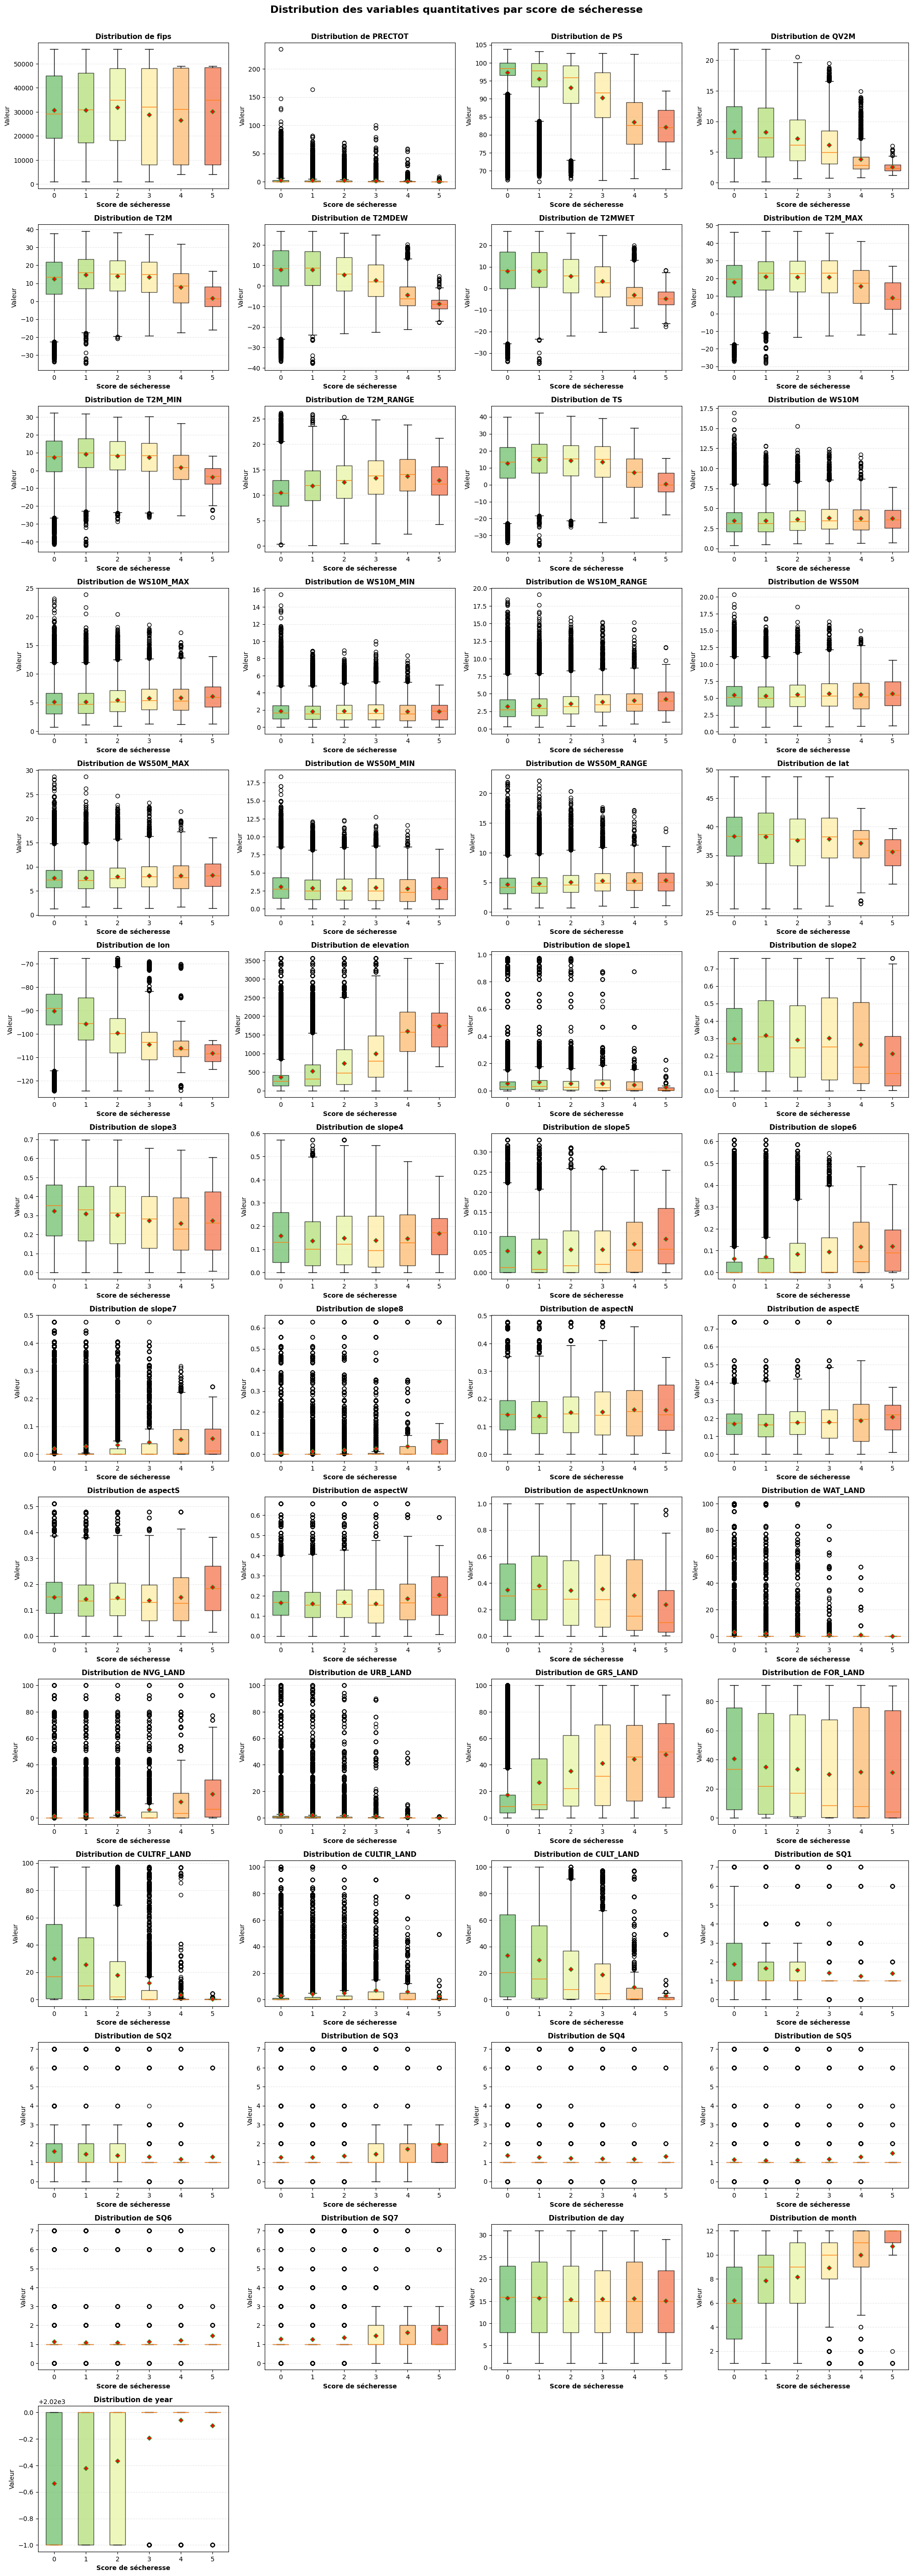

In [ ]:
# Calculer le nombre de lignes nécessaires
num_cols = 4  # Nombre de boxplots par ligne
num_rows = (len(quanti) + num_cols - 1) // num_cols

# Créer la figure avec subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Aplatir pour faciliter l'itération

# Créer un boxplot pour chaque variable
for i, col in enumerate(quanti):
    ax = axes[i]

    # Créer les données pour le boxplot
    data_to_plot = [X[X['score'] == score][col].dropna() for score in sorted(X['score'].unique())]

    # Créer le boxplot
    bp = ax.boxplot(data_to_plot,
                    labels=sorted(X['score'].unique()),
                    patch_artist=True,
                    showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=5))

    # Colorer les boxplots
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(data_to_plot)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Personnaliser le graphique
    ax.set_xlabel('Score de sécheresse', fontsize=10, fontweight='bold')
    ax.set_ylabel('Valeur', fontsize=10)
    ax.set_title(f'Distribution de {col}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

# Masquer les axes vides
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution des variables quantitatives par score de sécheresse',
             fontsize=16, fontweight='bold', y=1.002)
plt.tight_layout()
plt.show()

In [ ]:
X[["T2M_MAX", "T2M"]].corr()

T2M_MAX       T2M
T2M_MAX  1.000000  0.983759
T2M      0.983759  1.000000

In [ ]:
X[["T2M_MIN", "T2M"]].corr()

T2M_MIN       T2M
T2M_MIN  1.000000  0.982841
T2M      0.982841  1.000000

In [ ]:
X[["T2MDEW", "T2MWET"]].corr()

T2MDEW    T2MWET
T2MDEW  1.000000  0.998517
T2MWET  0.998517  1.000000

Les deux variables sont très corrélées, leur distribution en fonction du score sont très similaires. Pour cela on décide d'en garder une des deux pour chaque type d'indice.

In [ ]:
var_supp = ["T2M_MAX", "T2MWET", "T2M_MIN"] + var_supp

On pourrait également se dire que les variables WS10M, WS10M_MAX, WS10M_MIN, WS10M_RANGE sont également distribuées de façon similaire en fonction du score (à defalut de quelques valeurs extrêmes).

In [ ]:
X[["WS10M", "WS10M_MIN"]].corr()

WS10M  WS10M_MIN
WS10M      1.000000   0.826612
WS10M_MIN  0.826612   1.000000

In [ ]:
X[["WS10M", "WS10M_MAX"]].corr()

WS10M  WS10M_MAX
WS10M      1.000000   0.952133
WS10M_MAX  0.952133   1.000000

In [ ]:
X[["WS10M", "WS10M_RANGE"]].corr()

WS10M  WS10M_RANGE
WS10M        1.000000     0.715345
WS10M_RANGE  0.715345     1.000000

On juge que les corrélations sont pas assez élévées (par rapport aux variables T2M) pour les retirer du dataset. Même réflexion pour les variables décrivant l'indice de vitesse du vent WS50M.

In [ ]:
X[["WS50M", "WS50M_MIN"]].corr()

WS50M  WS50M_MIN
WS50M      1.000000   0.843382
WS50M_MIN  0.843382   1.000000

In [ ]:
X[["WS50M", "WS50M_MAX"]].corr()

WS50M  WS50M_MAX
WS50M      1.000000   0.919863
WS50M_MAX  0.919863   1.000000

In [ ]:
X[["WS50M", "WS50M_RANGE"]].corr()

WS50M  WS50M_RANGE
WS50M        1.000000     0.405609
WS50M_RANGE  0.405609     1.000000

In [ ]:
sampling_strategy = {
    0: 213018,
    1: 27626,
    2: 13349,
    3: 13000,
    4: 5000,
    5: 1000
}

smote = SMOTE(sampling_strategy = sampling_strategy, random_state=42)
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print(Counter(y_train_res))

Counter({0: 213018, 1: 27626, 2: 13349, 3: 13000, 4: 5000, 5: 1000})


On reapplique l'algorithme SMOTE à notre base standardisée.

In [ ]:
logit_multi_res = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,C=1, max_iter=1000, random_state=42, multi_class='multinomial')
logit_multi_res.fit(X_train_scaled_res, y_train_res)

C:\Users\hfsya\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, l1_ratio=0.5, max_iter=1000, multi_class='multinomial',
                   penalty='elasticnet', random_state=42, solver='saga')

## LOGISTIC REGRESSION : SMOTE

In [ ]:
y_pred_logit_multi_res = logit_multi_res.predict(X_test_scaled)
y_proba_logit_multi_res = logit_multi_res.predict_proba(X_test_scaled)

In [ ]:
print(classification_report(y_test, y_pred_logit_multi_res))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     53199
           1       0.10      0.00      0.00      6926
           2       0.13      0.00      0.00      3349
           3       0.26      0.33      0.30      1350
           4       0.41      0.49      0.45       402
           5       0.27      0.43      0.33        42

    accuracy                           0.82     65268
   macro avg       0.34      0.38      0.33     65268
weighted avg       0.71      0.82      0.75     65268



On remarque que les performances sur la classe minoritaire est meilleur ici.

In [ ]:
auc_macro_ovr_logit_multi_res = roc_auc_score(y_test, y_proba_logit_multi_res, multi_class="ovr", average="macro",labels=logit_multi_res.classes_)
print("AUC macro OVR =", auc_macro_ovr_logit_multi_res)

AUC macro OVR = 0.8573643940062098


In [ ]:
classes = logit_multi_res.classes_  # ordre des colonnes dans predict_proba
for j, c in enumerate(classes):
    y_true_bin = (y_test == c).astype(int)

    # Si la classe c n'existe pas dans y_test, AUC impossible
    if y_true_bin.sum() == 0 or y_true_bin.sum() == len(y_true_bin):
        print(f"AUC classe {c} : non définie (classe absente ou tous positifs)")
        continue

    y_score_c = y_proba_logit_multi_res[:, j]  # colonne correspondant à la classe c
    fpr, tpr, _ = roc_curve(y_true_bin, y_score_c)
    print(f"AUC classe {c} = {auc(fpr, tpr):.4f}")

AUC classe 0 = 0.7930
AUC classe 1 = 0.7069
AUC classe 2 = 0.7924
AUC classe 3 = 0.8899
AUC classe 4 = 0.9659
AUC classe 5 = 0.9961


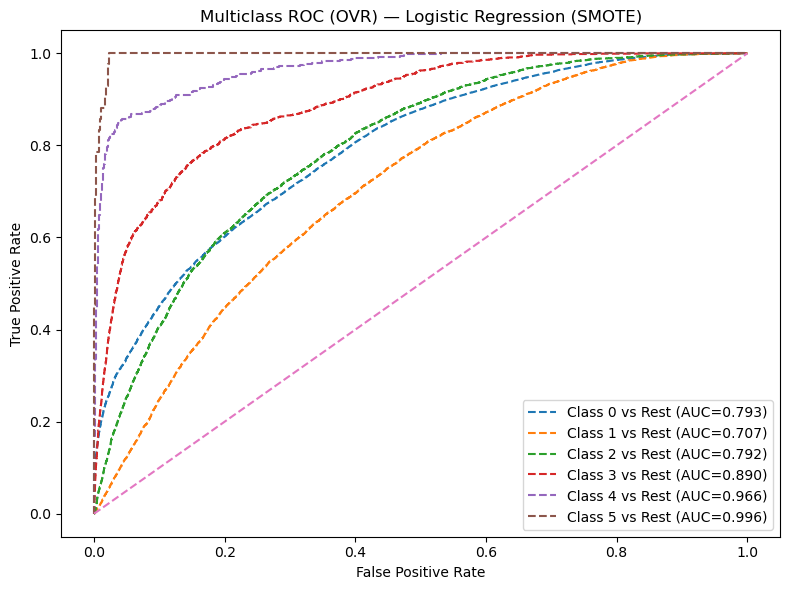

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = logit_multi_res.classes_
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin = y_test_bin[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score = y_proba_logit_multi_res[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — Logistic Regression (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


Sur les classes les plus rares le modèle avec SMOTE est beacoup plus performant.

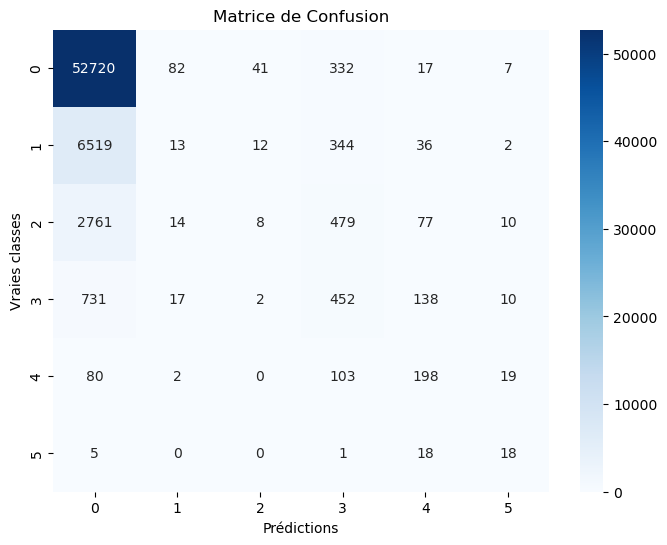

In [ ]:
cm = confusion_matrix(y_test, y_pred_logit_multi_res)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

On rapelle à travers un graphique le déséquilibre des classes

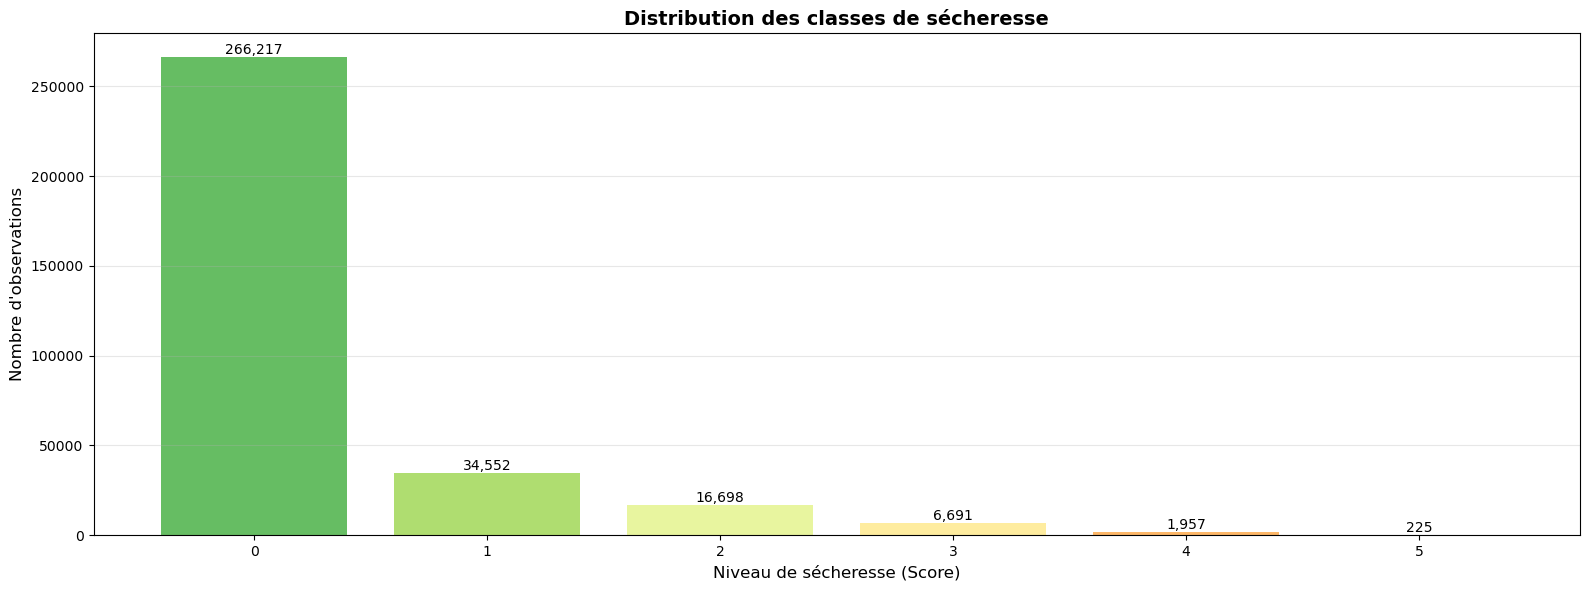

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Comptage par classe
score_counts = X["score"].value_counts().sort_index()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(score_counts)))

ax.bar(score_counts.index, score_counts.values, color=colors)
ax.set_xlabel("Niveau de sécheresse (Score)", fontsize=12)
ax.set_ylabel("Nombre d'observations", fontsize=12)
ax.set_title("Distribution des classes de sécheresse", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# Ajouter les valeurs sur les barres
for idx, val in score_counts.items():
    ax.text(idx, val, f"{val:,}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
df = X.drop(columns=var_supp)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df["score"], test_size=0.20, random_state=42)

On réalise le split train-test avant d'appliquer l'algorithme SMOTE afin d'éviter le DataLeakage.

In [ ]:
X_train["score"] == y_train #vérif

294559    True
24270     True
78609     True
238512    True
174372    True
          ... 
119879    True
259178    True
131932    True
146867    True
121958    True
Name: score, Length: 261072, dtype: bool

In [ ]:
X_test["score"] == y_test #vérif

212814    True
20908     True
111723    True
219392    True
16785     True
          ... 
209748    True
79927     True
129104    True
20233     True
201635    True
Name: score, Length: 65268, dtype: bool

In [ ]:
X_train = X_train.drop(columns="score")
X_test = X_test.drop(columns="score")

# MODELISATION BINAIRE

L'objectif de cette section est de transformer notre problématique de prédiction du score de sécheresse en classe binaire. Plutôt que de prédire le niveau précis de sévérité (de 0 à 5), nous nous concentrons ici sur une distinction : absence ou présence d'un état de sécheresse

In [ ]:
X['score'] = (X['score'] >= 1).astype(int)
print(X['score'].value_counts())

score
0    266217
1     60123
Name: count, dtype: int64


In [ ]:
df = X.drop(columns=var_supp)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df["score"], test_size=0.20, random_state=42)

In [ ]:
# Répartition de notre variable score
X_train["score"].value_counts()

score
0    213018
1     48054
Name: count, dtype: int64

In [ ]:
X_train["score"] == y_train

294559    True
24270     True
78609     True
238512    True
174372    True
          ... 
119879    True
259178    True
131932    True
146867    True
121958    True
Name: score, Length: 261072, dtype: bool

In [ ]:
X_test["score"] == y_test

212814    True
20908     True
111723    True
219392    True
16785     True
          ... 
209748    True
79927     True
129104    True
20233     True
201635    True
Name: score, Length: 65268, dtype: bool

In [ ]:
X_train = X_train.drop(columns="score")
X_test = X_test.drop(columns="score")

In [ ]:
nomi_features = ['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']
cat_indices = [X_train.columns.get_loc(col) for col in nomi_features if col in X_train.columns]

nomi_features contient les noms des colonnes qui ne sont pas des mesures numériques continues mais des variables qualitatives. SMOTE-NC a besoin de connaître les variables nominales pour appliquer un traitement différencié.

In [ ]:
print(f"Nombre de colonnes dans X_train : {X_train.shape[1]}")
print(f"Indices catégoriels détectés : {cat_indices}")

Nombre de colonnes dans X_train : 42
Indices catégoriels détectés : [32, 33, 34, 35, 36, 37, 38]


In [ ]:
# STRATÉGIES DE RÉÉCHANTILLONNAGE
strategies = {
    "1. Baseline": None,

    "2. Under-sampling": RandomUnderSampler(sampling_strategy='majority', random_state=42),

    "3. SMOTE Simple": Pipeline([
        # Traite les catégories comme des nombres (méthode "naïve")
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1))
    ]),

    "4. SMOTE-NC": Pipeline([
        # Méthode spécifique pour données mixtes du papier
        ('smotenc', SMOTENC(categorical_features=cat_indices, random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1))
    ]),

    "5. Combo SMOTE-NC + Under": Pipeline([
        ('smote', SMOTENC(categorical_features=cat_indices, sampling_strategy=0.5, random_state=42)),
        ('under', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1))
    ])
}

                       ANALYSE COMPARATIVE DES STRATÉGIES DE RÉÉQUILIBRAGE BINAIRE                       

TABLEAU DE SYNTHÈSE DES RÉSULTATS :
                Stratégie  Train_Size Ratio_0:1    TP   FP    TN   FN  Rappel_%  FPR_%    AUC  F1-Score
              1. Baseline      261072    4.43:1  6672  572 52627 5397     55.28   1.08 0.9585    0.6909
        2. Under-sampling       96108    1.00:1 11003 6794 46405 1066     91.17  12.77 0.9580    0.7368
          3. SMOTE Simple      426036    1.00:1 10680 6739 46460 1389     88.49  12.67 0.9503    0.7244
              4. SMOTE-NC      426036    1.00:1 10703 6852 46347 1366     88.68  12.88 0.9504    0.7226
5. Combo SMOTE-NC + Under      319527    2.00:1 10349 5127 48072 1720     85.75   9.64 0.9536    0.7514


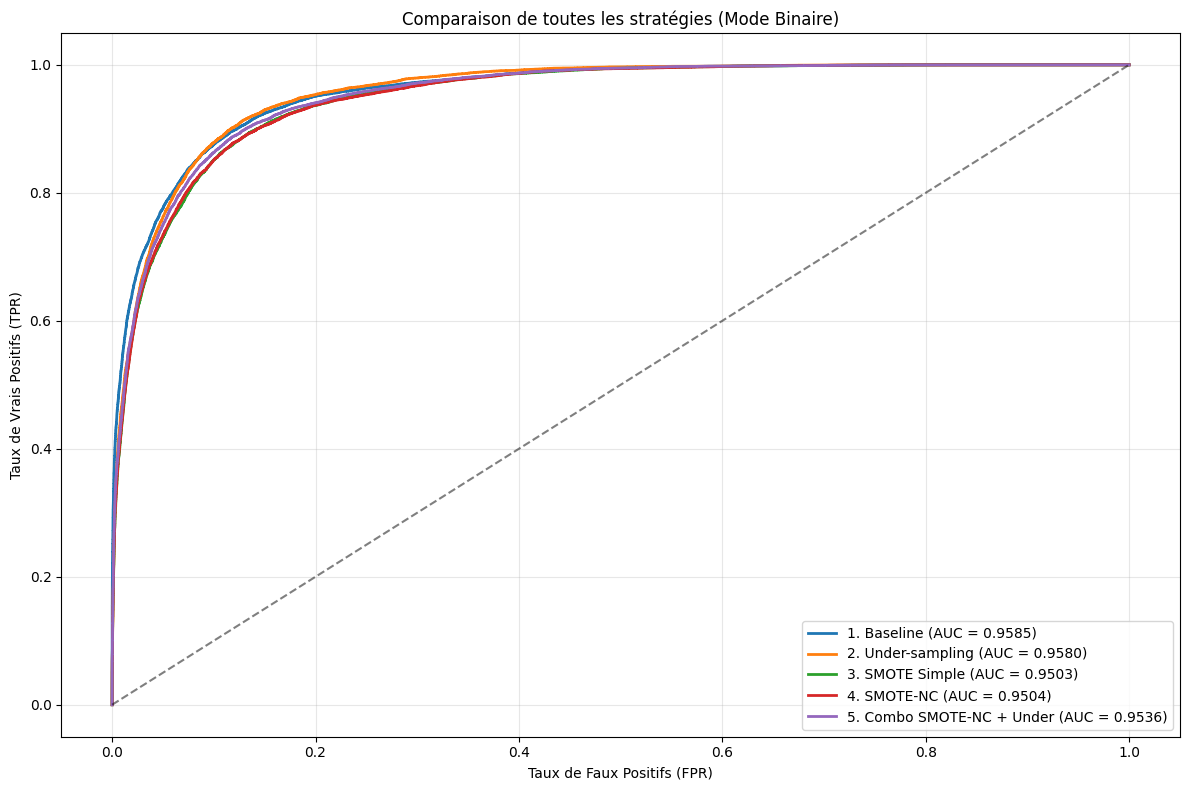

In [ ]:
results = []
plt.figure(figsize=(12, 8))

print(f"{'='*105}")
print(f"{'ANALYSE COMPARATIVE DES STRATÉGIES DE RÉÉQUILIBRAGE BINAIRE':^105}")
print(f"{'='*105}\n")

for name, model in strategies.items():
    # A. Entraînement et récupération des stats de volume
    if model is None:
        clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1).fit(X_train, y_train)
        y_res = y_train
    elif isinstance(model, RandomUnderSampler):
        X_res, y_res = model.fit_resample(X_train, y_train)
        clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1).fit(X_res, y_res)
    else:
        model.fit(X_train, y_train)
        _, y_res = model.steps[0][1].fit_resample(X_train, y_train)
        clf = model.named_steps['clf']

    # B. Prédictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # C. Calcul des métriques de performance
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    auc_score = roc_auc_score(y_test, y_proba)
    tpr = tp / (tp + fn)
    fpr_rate = fp / (fp + tn) # False Positive Rate

    # D. Stockage dans la liste des résultats
    results.append({
        "Stratégie": name,
        "Train_Size": len(y_res),
        "Ratio_0:1": f"{np.bincount(y_res)[0]/np.bincount(y_res)[1]:.2f}:1",
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Rappel_%": round(tpr * 100, 2),
        "FPR_%": round(fpr_rate * 100, 2),
        "AUC": round(auc_score, 4),
        "F1-Score": round(f1_score(y_test, y_pred), 4)
    })

    # E. Tracé de la courbe ROC (avec label corrigé pour la légende)
    fpr, tpr_curve, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr_curve, lw=2, label=f'{name} (AUC = {auc_score:.4f})')

# =================================================================
# 4. AFFICHAGE DU TABLEAU DE SYNTHÈSE ET DU GRAPHIQUE
# =================================================================
df_results = pd.DataFrame(results)

# Affichage du tableau final
print("TABLEAU DE SYNTHÈSE DES RÉSULTATS :")
print(df_results.to_string(index=False))

# Finalisation du graphique ROC
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Comparaison de toutes les stratégies (Mode Binaire)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

La Baseline est le modèle sans traitement. Il rate près de la moitié des épisodes de sécheresse (55,28%). Nous avons 5397 Faux Négatifs, ce modèle n'est pas viable.
Les deux versions de SMOTE montrent des résultats très proches. Le fait que SMOTE-NC ne surpasse pas nettement le SMOTE simple suggère que les variables météorologiques continues dominent fortement la décision par rapport aux autres variables. SMOTE-NC reste le choix le plus rigoureux car il évite la création de valeurs aberrantes.
La dernière stratégie a un F1-score optimal (0.7514) c'est la valeur la plus haute. Elle offre la meilleure moyenne entre Précision et Rappel.Le taux de fausses alertes est de 9.64% il est nettement mieux maitrisé par rapport aux autres méthodes.

# ANNEXE : MODELISATION MULTI-CLASSE

## RANDOM FOREST

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

Le modèle Random Forest a été choisi pour sa robustesse face au sur-apprentissage, sa capacité à capturer des relations non linéaires complexes et son excellent compromis entre performance prédictive et simplicité de mise en œuvre.

On commence par faire la prédiction sans effectuer de rééchantillonage afin de pouvoir comparer les résultat par la suite.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

n_jobs : L’entraînement du modèle Random Forest a été parallélisé à l’aide du paramètre n_jobs afin d’exploiter les capacités multi-cœurs du processeur. La parallélisation a été contrôlée afin d’éviter une duplication excessive de la mémoire lors des phases de validation croisée.

max_depth : La profondeur maximale des arbres n’a pas été contrainte afin de permettre au modèle de capturer des interactions complexes entre les variables. Contrairement à un arbre decision, le risque de sur-apprentissage est limité par l’agrégation d’un grand nombre d’arbres entraînés sur des sous-échantillons aléatoires des données.

n_estimators : Le nombre d’arbres a été fixé à 300 afin d’assurer la stabilité des performances du modèle. Au-delà de ce seuil, l’augmentation du nombre d’arbres n’entraîne généralement qu’un gain marginal en performance, au prix d’un coût de calcul plus élevé.

In [ ]:
y_pred_rf = rf.predict(X_test)

print("F1 macro :", f1_score(y_test, y_pred_rf, average="macro"))
print(classification_report(y_test, y_pred_rf))

F1 macro : 0.7487990739022988
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     53199
           1       0.79      0.57      0.66      6926
           2       0.80      0.69      0.74      3349
           3       0.83      0.76      0.79      1350
           4       0.83      0.79      0.81       402
           5       0.80      0.38      0.52        42

    accuracy                           0.93     65268
   macro avg       0.83      0.70      0.75     65268
weighted avg       0.92      0.93      0.92     65268



Le recall et le F1-score sont trois métriques courantes pour évaluer un modèle de classification (surtout quand les classes sont déséquilibrées).

Precision (précision) : La precision est assez similaire au recall, il faut donc bien comprendre leur différence.
Elle permet de connaître le nombre de prédictions positifs bien effectuée

En d’autres termes c’est le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit (Vrai Positif + Faux PositPlus elle est élevé, plus le modèle de Machine Learning minimise le nombre de Faux Positif.
Quand la précision est haute, cela veut dire que la majorité des prédictions positives du modèle sont des positifs bien prédi Néanmoins cela ne donne aucune information sur sa qualité de prédiction sur les négatifs.t.f)..

Recall (Rappel) : Le recall permet de savoir le pourcentage de positifs bien prédit par notre m dèle.

En d’autres termes c’est le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs (Vrai Positif + Faux Négatif Plus il est élevé, plus le modèle de Machine Learning maximise le nombre de Vrai Positif.

Quand le recall est haut, cela veut plutôt dire qu’il ne ratera aucun positif. Néanmoins cela ne donne aucune information sur sa qualité de prédiction sur lesnégat
ifs.).

F1-score : c’est un compromis entre precision et recall. Il correspond à leur moyenne harmonique, donc il devient faible dès que l’une des deux métriques Plus le F1 Score est élevé, plus le modèle est performant.re les deux.

In [ ]:
y_proba_rf = rf.predict_proba(X_test)

In [ ]:
auc_macro_ovr_rf = roc_auc_score(
    y_test,
    y_proba_rf,
    multi_class="ovr",
    average="macro"
)

print("AUC ROC macro (OvR) :", auc_macro_ovr_rf)

AUC ROC macro (OvR) : 0.9899693707537027


In [ ]:
from sklearn.metrics import roc_curve, auc

for k in range(0,6):
    y_true_bin = (y_test == k).astype(int)
    y_score_k = y_proba_rf[:, k]

    fpr, tpr, _ = roc_curve(y_true_bin, y_score_k)
    print("AUC classe", k, "=", auc(fpr, tpr))

AUC classe 0 = 0.9880914500016352
AUC classe 1 = 0.9695216409562172
AUC classe 2 = 0.9881681792051783
AUC classe 3 = 0.9951600256346963
AUC classe 4 = 0.9989879058749971
AUC classe 5 = 0.9998870228494918


Un avantage majeur de la ROC AUC est son insensibilité au déséquilibre des classes. La ROC AUC fournit une évaluation équilibrée de la performance du modèle.

Bien que la ROC AUC soit principalement associée à la classification binaire, elle peut être étendue aux problèmes multi-classes. Une méthode courante est l’approche « un-contre-tous », où des courbes ROC séparées sont générées pour chaque classe contre toutes les autres.

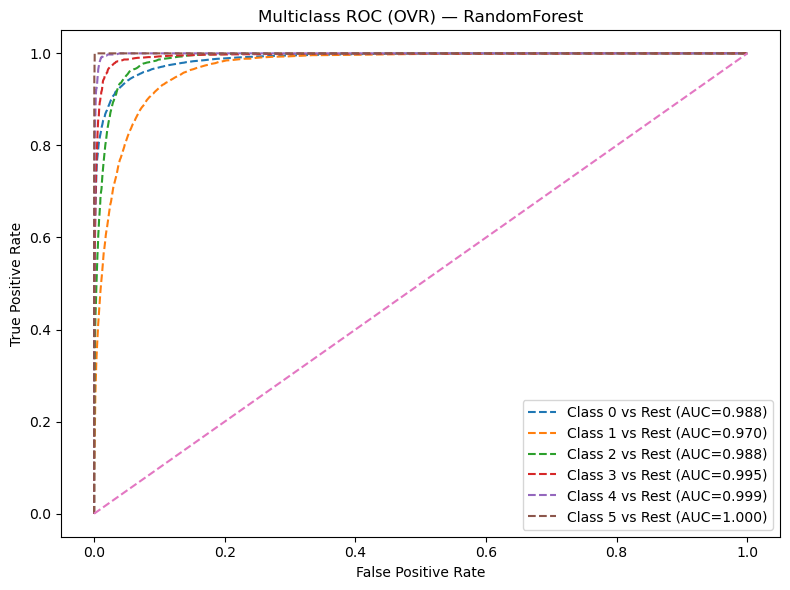

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = rf.classes_
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin = y_test_bin[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score = y_proba_rf[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — RandomForest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


Plus la courbe est proche du coin supérieur gauche, plus le modèle est un bon classificateur.

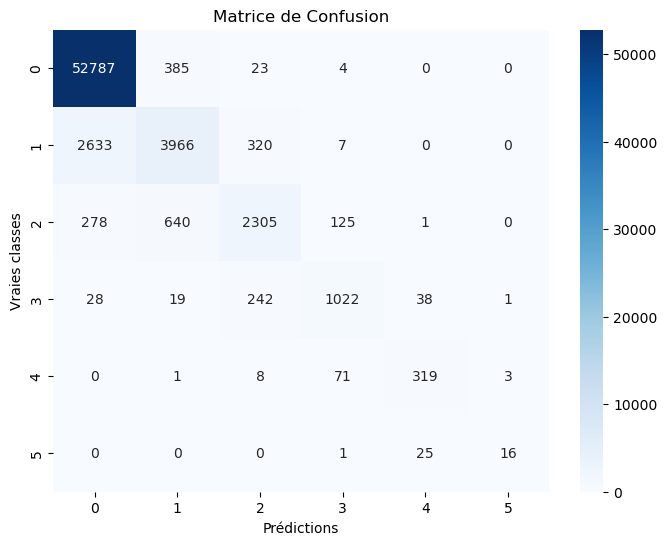

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

## SMOTE

In [ ]:
y_train.value_counts()

score
0    213018
1     27626
2     13349
3      5341
4      1555
5       183
Name: count, dtype: int64

Constat : déséquilibre massif de la variable cible

La variable cible score est répartie de manière très inégale : la classe 0 apparaît 213 018 fois alors que la classe la plus rare (5) n’apparaît que 183 fois. Cela correspond à un rapport d’environ 1164:1 entre la classe majoritaire et la plus minoritaire.
Un tel déséquilibre est problématique car un modèle peut obtenir une bonne accuracy globale en prédisant majoritairement la classe 0, tout en échouant à détecter les classes rares (celles qui sont souvent les plus importantes). Pour limiter ce biais d’apprentissage, on met en place des stratégies de rééquilibrage sur l’échantillon d’entraînement.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

Sur-échantillonner trop loin du support réel de la classe peut devenir peu crédible statistiquement. Un équilibrage partiel crédible doit rester proche de la densité réelle de chaque classe. On décide de ne pas sur-échantillonner au-delà de la classe immédiatement au-dessus. Les classes rares restent plus rares, mais moins extrêmes. Cette approche de rééquilibrage partiel améliore la capacité du modèle à “voir” suffisamment d’exemples des classes rares, sans sur-générer des données synthétiques au point de déformer fortement la distribution. De plus cela permet de réduire le coût computationnel engendré par un grand nombre de lignes.

On décide de ne pas sur-échantillonner au delà du nombre d'observations de la classe immédiatement supérieure et on décide de sur-échantillonger uniquement les classes très rares (3, 4 et 5).

In [ ]:
sampling_strategy = {
    0: 213018,
    1: 27626,
    2: 13349,
    3: 13000,
    4: 5000,
    5: 1000
}

In [ ]:
smote = SMOTE(
    sampling_strategy = sampling_strategy,
    random_state=42
)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(Counter(y_train_res))

Counter({0: 213018, 1: 27626, 2: 13349, 3: 13000, 4: 5000, 5: 1000})


## RANDOM FOREST : SMOTE

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [ ]:
rf_res_bis = RandomForestClassifier(
    n_estimators=300,     # valeur standard et robuste
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_res_bis.fit(X_train_res_bis, y_train_res_bis)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf_res_bis = rf_res_bis.predict(X_test)

print("F1 macro :", f1_score(y_test, y_pred_rf_res_bis, average="macro"))
print(classification_report(y_test, y_pred_rf_res_bis))

F1 macro : 0.7927176313804031
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     53199
           1       0.80      0.57      0.66      6926
           2       0.81      0.66      0.73      3349
           3       0.76      0.82      0.79      1350
           4       0.84      0.81      0.83       402
           5       0.80      0.76      0.78        42

    accuracy                           0.93     65268
   macro avg       0.83      0.77      0.79     65268
weighted avg       0.92      0.93      0.92     65268



* Ce qu'on peut dire déjà c'est que le modèle améliore nettement le f1-score des classes minoritaires. Pour la classe la plus rare (5), 0,76 vs 0,38 pour le recall et 0,78 vs 0,52 pour le f1 score.
* Le f1-score macro passe de 0,74 à 0,79

In [ ]:
y_proba_rf_res_bis = rf_res_bis.predict_proba(X_test)

In [ ]:
auc_macro_ovr_res_bis = roc_auc_score(
    y_test,
    y_proba_rf_res_bis,
    multi_class="ovr",
    average="macro"
)

print("AUC ROC macro (OvR) :", auc_macro_ovr_res_bis)

AUC ROC macro (OvR) : 0.989930419866769


In [ ]:
from sklearn.metrics import roc_curve, auc

for k in range(0,6):
    y_true_bin_bis = (y_test == k).astype(int)
    y_score_k_bis = y_proba_rf_res_bis[:, k]

    fpr, tpr, _ = roc_curve(y_true_bin_bis, y_score_k_bis)
    print("AUC classe", k, "=", auc(fpr, tpr))

AUC classe 0 = 0.9878010482190607
AUC classe 1 = 0.969441941976698
AUC classe 2 = 0.9883219357882437
AUC classe 3 = 0.9952314423688685
AUC classe 4 = 0.9989086188089553
AUC classe 5 = 0.9998775320387867


Constat :
* Pour presque toutes les classes (sauf classe 3 et classe 2) l'AUC est légérement meilleur en appliquant le SMOTE.
* L'AUC macro diminue très légèrement dû à une légére diminution sur les classes plus intermédiaires (2 et 3)
* Les résultats restent globalement très bons

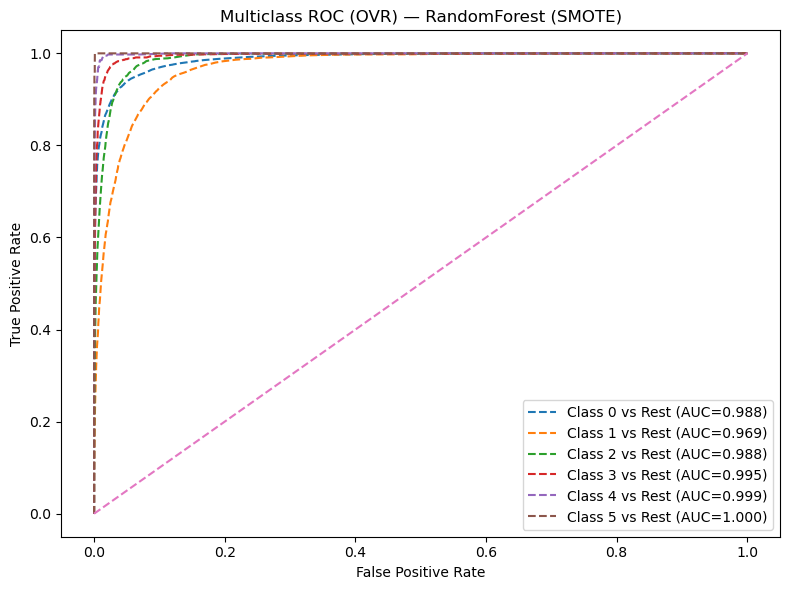

In [ ]:
# Probabilités (n_samples, n_classes)
y_proba_rf_res_bis = rf_res_bis.predict_proba(X_test)

# Important : ordre des classes correspondant aux colonnes
classes = rf_res_bis.classes_
y_test_bin_bis = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin_bis = y_test_bin_bis[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin_bis.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score_bis = y_proba_rf_res_bis[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin_bis, y_score_bis)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — RandomForest (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


Le modèle est très performant sur toutes les classes, et spécialement les classes minoritaire ce qui est le plus important.
On a bon compromis perfomance - coût de calcul, car on a décidé de ne pas mettre toutes les classes sur le même niveau c'est à dire à plus de 200k).

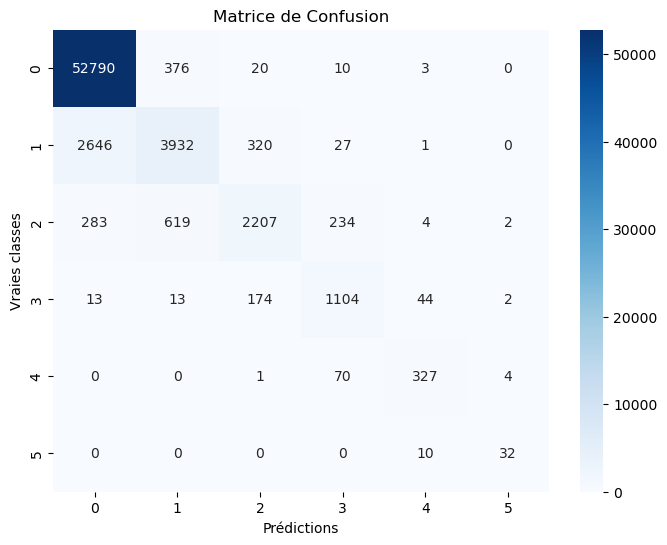

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf_res_bis)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

## RANDOM FOREST : SMOTE + UNDERSAMPLING

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
# SMOTE : on garde la stratégie de sur-échantillonage précente
smote_strategy_bis = {
    2: 13439,
    3: 13000,
    4: 5000,
    5: 1000
}

# Under-sampling : on sous-échantillonne la classe majoritaire 0 à 100k (on pourrait choisir un autre nombre)
under_strategy_bis = {
    0: 100000,
    1: 27626,
    2: 13439,
    3: 13000,
    4: 5000,
    5: 1000
}

resampler_bis = Pipeline(steps=[
    ("smote", SMOTE(sampling_strategy=smote_strategy_bis, k_neighbors=5, random_state=42)),
    ("under", RandomUnderSampler(sampling_strategy=under_strategy_bis, random_state=42)),
])

X_train_res_v2_bis, y_train_res_v2_bis = resampler_bis.fit_resample(X_train, y_train)

In [ ]:
rf_res_v2_bis = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_res_v2_bis.fit(X_train_res_v2_bis, y_train_res_v2_bis)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf_res_v2_bis = rf_res_v2_bis.predict(X_test)

print("Classification Report for Random Forest (Multiclass with SMOTE):\n")
print(classification_report(y_test, y_pred_rf_res_v2_bis, zero_division=0))

Classification Report for Random Forest (Multiclass with SMOTE):

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     53199
           1       0.71      0.72      0.71      6926
           2       0.79      0.67      0.73      3349
           3       0.76      0.82      0.79      1350
           4       0.84      0.81      0.83       402
           5       0.82      0.76      0.79        42

    accuracy                           0.93     65268
   macro avg       0.81      0.79      0.80     65268
weighted avg       0.93      0.93      0.93     65268



Constat :
* Le f1-score macro augmente encore par rapport au simple sur-échantillonage (SMOTE) : de 0.79 à 0.8
* Le f1-score par classe augmente également sur la classe la plus rare (5 : de 0.78 à 0.79) mais également sur une classe "intérmédiaire" (1 : de 0.66 à 0.71). Sur les autres classes cette métrique reste stable et bonne.
* De même pour le recall et la précision.

Donc cette méthode au vu des métriques précisées ici, permet d'améliorer les performances sur les classes minoritaires, mais également sur les classes plus représentées. Tout en restant stable et performant sur la classe majoritaire. C'est donc un meilleur classificateur, ceci est bien en cohérence avec les résultats du papier de recherche.

In [ ]:
y_proba_rf_res_v2_bis = rf_res_v2_bis.predict_proba(X_test)
print(y_proba_rf_res_v2_bis.shape)  # doit afficher (n_samples, 6)

(65268, 6)


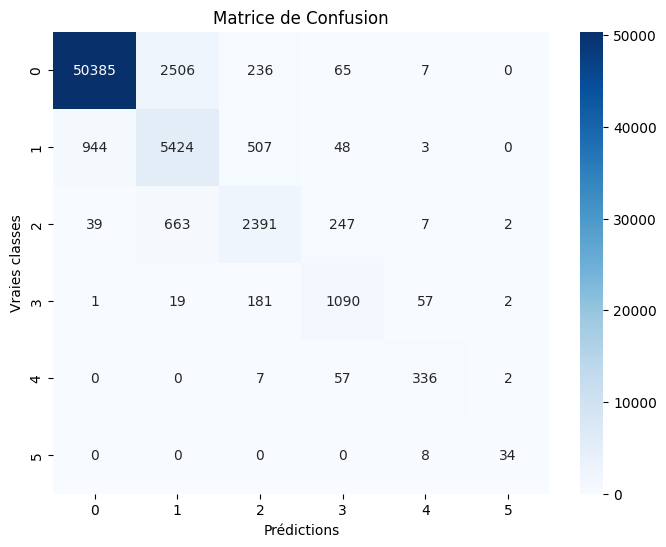

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf_res_v2_bis)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
auc_macro_ovr_res_v2_bis = roc_auc_score(y_test, y_proba_rf_res_v2_bis, multi_class="ovr", average="macro")
print("AUC macro OVR =", auc_macro_ovr_res_v2_bis)

AUC macro OVR = 0.9862173516636586


In [ ]:
from sklearn.metrics import roc_curve, auc

for k in range(0,6):
    y_true_bin_bis = (y_test == k).astype(int)
    y_score_k_bis = y_proba_rf_res_v2_bis[:, k]

    fpr, tpr, _ = roc_curve(y_true_bin_bis, y_score_k_bis)
    print("AUC classe", k, "=", auc(fpr, tpr))

AUC classe 0 = 0.9821625912910451
AUC classe 1 = 0.9587274808713786
AUC classe 2 = 0.9840499993222153
AUC classe 3 = 0.9941930807180033
AUC classe 4 = 0.9983102171748479
AUC classe 5 = 0.9998607406044624


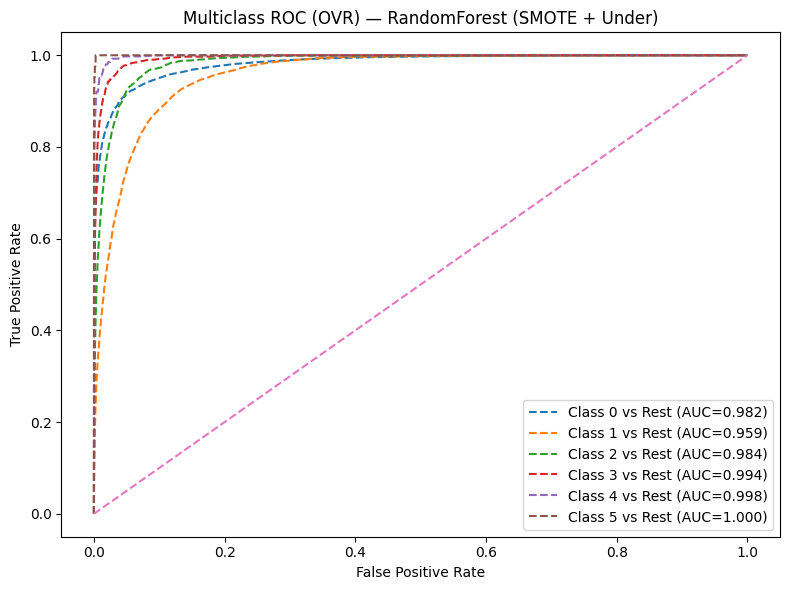

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = rf_res_v2_bis.classes_
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin = y_test_bin[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score_bis = y_proba_rf_res_v2_bis[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score_bis)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — RandomForest (SMOTE + Under)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


Conclusion :
* L'AUC par classereste inchangée lorsqu'on compare SMOTE et SMOTE+UNDERSAM. En terme de coût computationnel on va préférer donc le SMOTE + UNDERSAMPLING, car il est plus rapide et permet d'avoir des résultats similaires sur l'AUC et meilleurs sur les autres métriques (f1-score, recall etc).
* Les résultats obtenus en rééchantillonant sont nettement meilleurs sur les classes minoritaires et légérement meilleurs sur les classes intermédiaires et majoritaires.

## RANDOM FOREST : SMOTE NC

In [ ]:
from imblearn.over_sampling import SMOTENC
from collections import Counter

In [ ]:
sampling_strategy = {
    0: 213018,
    1: 27626,
    2: 13349,
    3: 13000,
    4: 5000,
    5: 1000
}

cat_cols = ["fips","year", "month", "day",'SQ1','SQ2','SQ3','SQ4','SQ5','SQ6','SQ7']
cat_indices = [X_train.columns.get_loc(col) for col in cat_cols]

smotenc = SMOTENC(
    sampling_strategy = sampling_strategy,
    categorical_features = cat_indices,
    random_state=42
)

X_train_res_nc, y_train_res_nc = smotenc.fit_resample(X_train, y_train)
print(Counter(y_train_res_nc))

Counter({0: 213018, 1: 27626, 2: 13349, 3: 13000, 4: 5000, 5: 1000})


In [ ]:
rf_res_nc = RandomForestClassifier(
    n_estimators=300,     # valeur standard et robuste
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_res_nc.fit(X_train_res_nc, y_train_res_nc)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf_res_nc = rf_res_nc.predict(X_test)

print("F1 macro :", f1_score(y_test, y_pred_rf_res_nc, average="macro"))
print(classification_report(y_test, y_pred_rf_res_nc))

F1 macro : 0.7896010115067194
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     53199
           1       0.79      0.57      0.66      6926
           2       0.81      0.66      0.73      3349
           3       0.78      0.83      0.80      1350
           4       0.86      0.82      0.84       402
           5       0.78      0.69      0.73        42

    accuracy                           0.93     65268
   macro avg       0.83      0.76      0.79     65268
weighted avg       0.92      0.93      0.92     65268



Constat :
* Les résulats sur les métriques ci-dessus, sont smilaires sur la classe majoritaire et les classes intermédiaires. En revanche sur la classe minoritaire (5) les résultats sont meilleurs avec le SMOTE simple. Ceci est contradictoire avec ce qui a été suggéré dans le papier. Nous pouvons justifier cela par le fait que les variables catégorielles sont moins nobreuses que les variables numériques, donc elles n'ont pas beaucoup d'impact sur les résultats.

In [ ]:
y_proba_rf_res_nc = rf_res_nc.predict_proba(X_test)

In [ ]:
auc_macro_ovr_res_nc = roc_auc_score(
    y_test,
    y_proba_rf_res_nc,
    multi_class="ovr",
    average="macro"
)

print("AUC ROC macro (OvR) :", auc_macro_ovr_res_nc)

AUC ROC macro (OvR) : 0.9901888418112704


In [ ]:
from sklearn.metrics import roc_curve, auc

for k in range(0,6):
    y_true_bin_bis = (y_test == k).astype(int)
    y_score_k_bis = y_proba_rf_res_nc[:, k]

    fpr, tpr, _ = roc_curve(y_true_bin_bis, y_score_k_bis)
    print("AUC classe", k, "=", auc(fpr, tpr))

AUC classe 0 = 0.9880700306215445
AUC classe 1 = 0.9698539701963308
AUC classe 2 = 0.9886743862495474
AUC classe 3 = 0.995813565528982
AUC classe 4 = 0.9988645555253364
AUC classe 5 = 0.9998565427458813


Constat :
* Pour les classes (0,1,2,3) l'AUC est légérement meilleur en appliquant le SMOTE NC. En revanche sur les classes très rares (4 et 5), l'AUC issu de la méthode SMOTE est meilleur. On préfère donc le modèle avec SMOTE.
* L'AUC macro augmente très légèrement, en appliquant le SMOTE NC, dû à une légére augmentation sur les classes plus intermédiaires (1, 2 et 3) et majoritaire.
* Les résultats restent globalement très bons

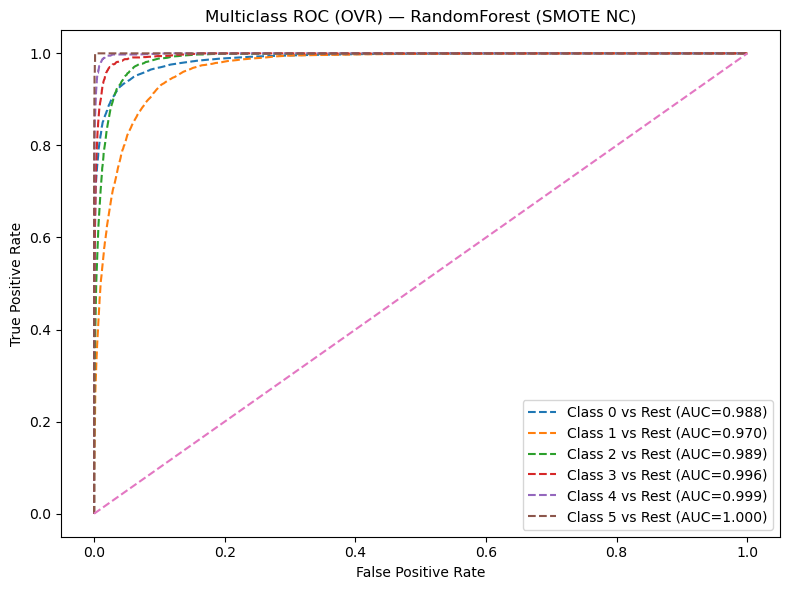

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = rf_res_nc.classes_
y_test_bin_bis = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin_bis = y_test_bin_bis[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin_bis.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score_bis = y_proba_rf_res_nc[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin_bis, y_score_bis)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — RandomForest (SMOTE NC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


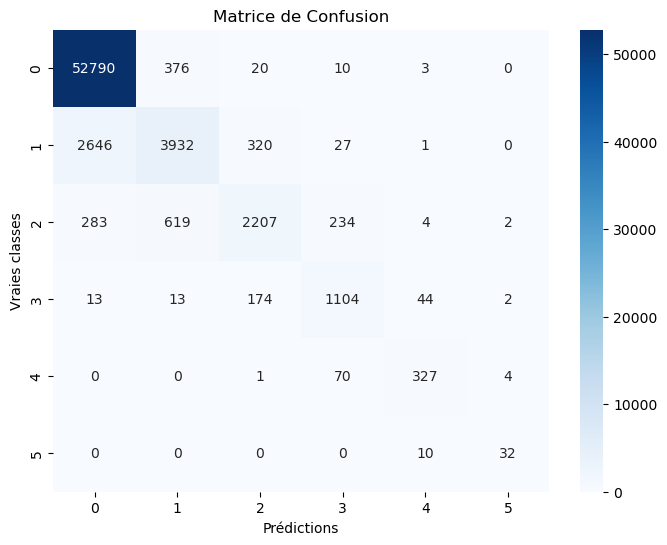

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf_res_nc)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

## LOGISTIC REGRESSION MULTICLASS

Dans le cadre de cette étude, connaître l'effet de chaque indice/ variable de notre base de données sur le score de sécheresse est une information importante.  Contrairement aux modèles de type « boîte noire », tels que les forêts aléatoires ou les méthodes de boosting, la régression logistique permet d’analyser explicitement l’influence des différents indices météorologiques et variables géographiques sur la probabilité d’appartenance à chaque niveau de score de sécheresse.
Pour cela la régression logistique multinomiale a été retenue comme modèle en raison de son haut niveau d’interprétabilité.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Contrairement aux modèles de boosting (XGboost) ou bagging (random forest) tels que random forest ou Xgboost qui se basent sur des seuils et des comparaisons, les modèles linéaires sont sensiblent aux échelles. Donc on standardisent nos données pour ce modèle.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
logit_multi = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,C=1, max_iter=1000, random_state=42, multi_class='multinomial')
logit_multi.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, l1_ratio=0.5, max_iter=1000, multi_class='multinomial',
                   penalty='elasticnet', random_state=42, solver='saga')

Texte pénalisation elastic net :

In [ ]:
y_pred_logit_multi = logit_multi.predict(X_test_scaled)

print("F1 macro:", f1_score(y_test, y_pred_logit_multi, average="macro"))
print(classification_report(y_test, y_pred_logit_multi))

F1 macro: 0.30579045048641945
              precision    recall  f1-score   support

           0       0.83      0.99      0.91     53199
           1       0.15      0.01      0.02      6926
           2       0.34      0.05      0.08      3349
           3       0.42      0.14      0.20      1350
           4       0.49      0.46      0.48       402
           5       0.33      0.10      0.15        42

    accuracy                           0.82     65268
   macro avg       0.43      0.29      0.31     65268
weighted avg       0.72      0.82      0.75     65268



On veut à présent connaître les effets des variables sur le score de sécheresse.

In [ ]:
feature_names = X_train.columns

coef = pd.DataFrame(
    logit_multi.coef_,
    columns=feature_names,
    index=[f"classe_{c}" for c in logit_multi.classes_]
)

intercept = pd.Series(logit_multi.intercept_, index=coef.index, name="intercept")
coef.head()


In [ ]:
y_proba_logit_multi = logit_multi.predict_proba(X_test_scaled)

In [ ]:
y_proba_logit_multi.shape #verif

(65268, 6)

In [ ]:
auc_macro_ovr_logit_multi = roc_auc_score(y_test, y_proba_logit_multi, multi_class="ovr", average="macro",labels=logit_multi.classes_)
print("AUC macro OVR =", auc_macro_ovr_logit_multi)

AUC macro OVR = 0.8574565775031782


In [ ]:
classes = logit_multi.classes_  # ordre des colonnes dans predict_proba
for j, c in enumerate(classes):
    y_true_bin = (y_test == c).astype(int)

    # Si la classe c n'existe pas dans y_test, AUC impossible
    if y_true_bin.sum() == 0 or y_true_bin.sum() == len(y_true_bin):
        print(f"AUC classe {c} : non définie (classe absente ou tous positifs)")
        continue

    y_score_c = y_proba_logit_multi[:, j]  # colonne correspondant à la classe c
    fpr, tpr, _ = roc_curve(y_true_bin, y_score_c)
    print(f"AUC classe {c} = {auc(fpr, tpr):.4f}")

AUC classe 0 = 0.7922
AUC classe 1 = 0.7088
AUC classe 2 = 0.7952
AUC classe 3 = 0.8902
AUC classe 4 = 0.9639
AUC classe 5 = 0.9944


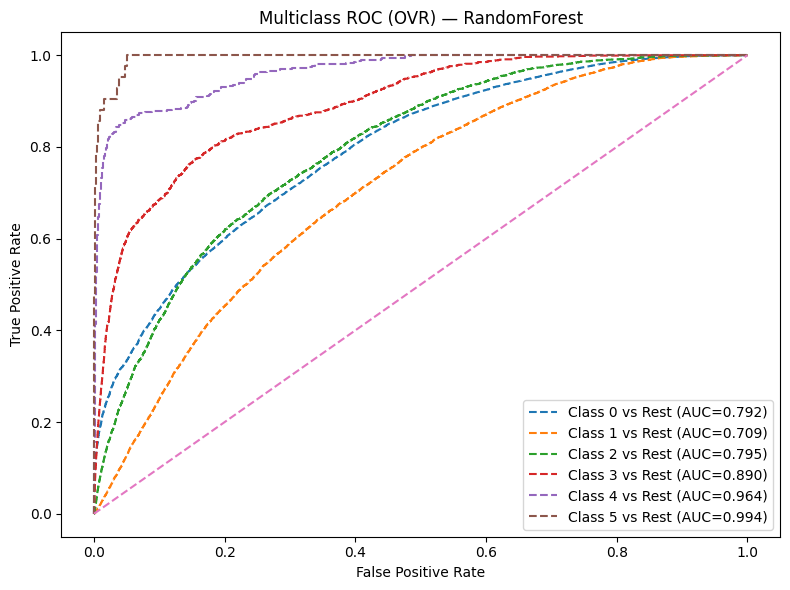

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = logit_multi.classes_
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin = y_test_bin[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score = y_proba_logit_multi[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


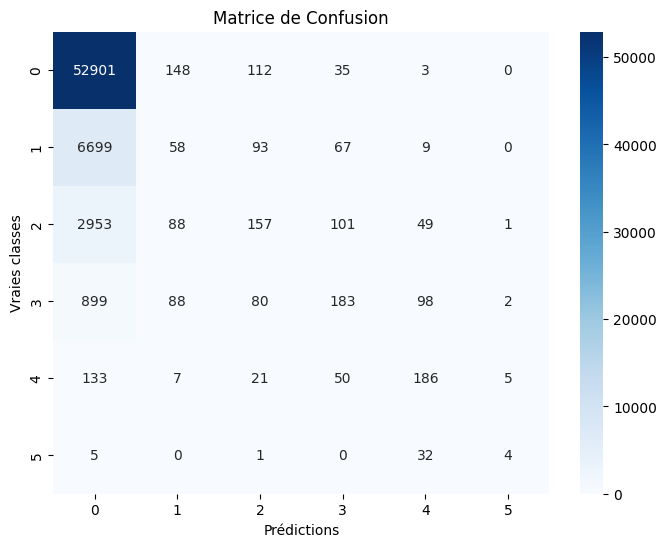

In [ ]:
cm = confusion_matrix(y_test, y_pred_logit_multi)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

## LOGISTIC REGRESSION : SMOTE

In [ ]:
sampling_strategy = {
    0: 213018,
    1: 27626,
    2: 13349,
    3: 13000,
    4: 5000,
    5: 1000
}

smote = SMOTE(sampling_strategy = sampling_strategy, random_state=42)
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print(Counter(y_train_res))

Counter({0: 213018, 1: 27626, 2: 13349, 3: 13000, 4: 5000, 5: 1000})


On reprend la même stratégie appliquée pour le random forest, toujours pour les mêmes raisons.

On reapplique l'algorithme SMOTE à notre base standardisée.

In [ ]:
logit_multi_res = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,C=1, max_iter=1000, random_state=42, multi_class='multinomial')
logit_multi_res.fit(X_train_scaled_res, y_train_res)

C:\Users\hfsya\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, l1_ratio=0.5, max_iter=1000, multi_class='multinomial',
                   penalty='elasticnet', random_state=42, solver='saga')

In [ ]:
y_pred_logit_multi_res = logit_multi_res.predict(X_test_scaled)
y_proba_logit_multi_res = logit_multi_res.predict_proba(X_test_scaled)

In [ ]:
print(classification_report(y_test, y_pred_logit_multi_res))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     53199
           1       0.10      0.00      0.00      6926
           2       0.13      0.00      0.00      3349
           3       0.26      0.33      0.30      1350
           4       0.41      0.49      0.45       402
           5       0.27      0.43      0.33        42

    accuracy                           0.82     65268
   macro avg       0.34      0.38      0.33     65268
weighted avg       0.71      0.82      0.75     65268



Constat :

*   Le f1-score macro est légèrement supérieur lorsqu'on applique la méthode SMOTE
*   Le f1-score reste  stable sur la classe majoritaire, très faible sur les classes intérmédiaires (1, 2 et 3). En revanche sur la classe minoritaire il a doublé en passe de 0.15 à 0.33.
*   De même pour le recall, on passe de 0.10 à 0.43 pour la classe 5.
*   Les résultats restent très mauvais pour toutes les classes, sauf pour la classe majoritaire (0).



In [ ]:
auc_macro_ovr_logit_multi_res = roc_auc_score(y_test, y_proba_logit_multi_res, multi_class="ovr", average="macro",labels=logit_multi_res.classes_)
print("AUC macro OVR =", auc_macro_ovr_logit_multi_res)

AUC macro OVR = 0.8573643940062098


L'AUC macro reste stable.

In [ ]:
classes = logit_multi_res.classes_  # ordre des colonnes dans predict_proba
for j, c in enumerate(classes):
    y_true_bin = (y_test == c).astype(int)

    # Si la classe c n'existe pas dans y_test, AUC impossible
    if y_true_bin.sum() == 0 or y_true_bin.sum() == len(y_true_bin):
        print(f"AUC classe {c} : non définie (classe absente ou tous positifs)")
        continue

    y_score_c = y_proba_logit_multi_res[:, j]  # colonne correspondant à la classe c
    fpr, tpr, _ = roc_curve(y_true_bin, y_score_c)
    print(f"AUC classe {c} = {auc(fpr, tpr):.4f}")

AUC classe 0 = 0.7930
AUC classe 1 = 0.7069
AUC classe 2 = 0.7924
AUC classe 3 = 0.8899
AUC classe 4 = 0.9659
AUC classe 5 = 0.9961


Les AUC par classe restent relativement stables sur les deux méthodes, avec tout de même de légères améliorations sur les classes les plus rares.

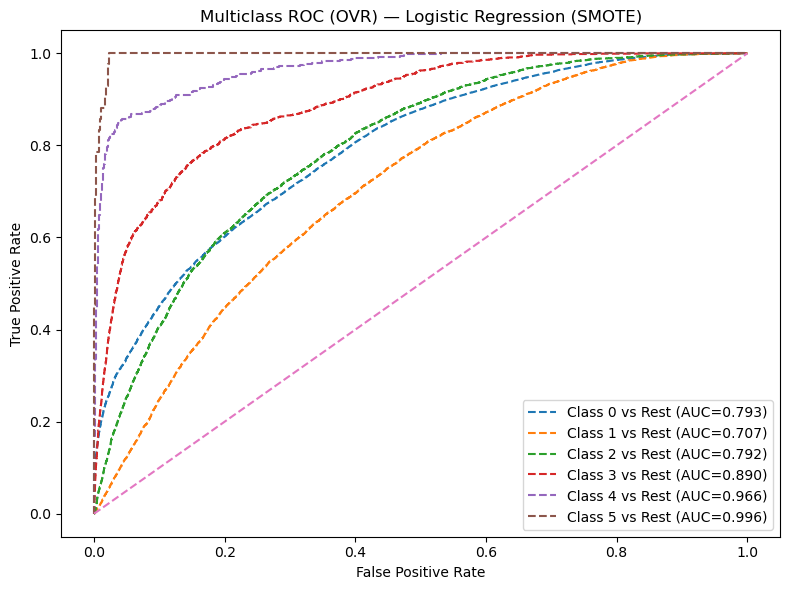

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = logit_multi_res.classes_
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin = y_test_bin[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score = y_proba_logit_multi_res[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — Logistic Regression (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


Sur les classes les plus rares le modèle avec SMOTE est plus performant sur les classes minoritaires et équivalent sur les autres classes. On a un gain marginal de performance sur les classes minoritaires.

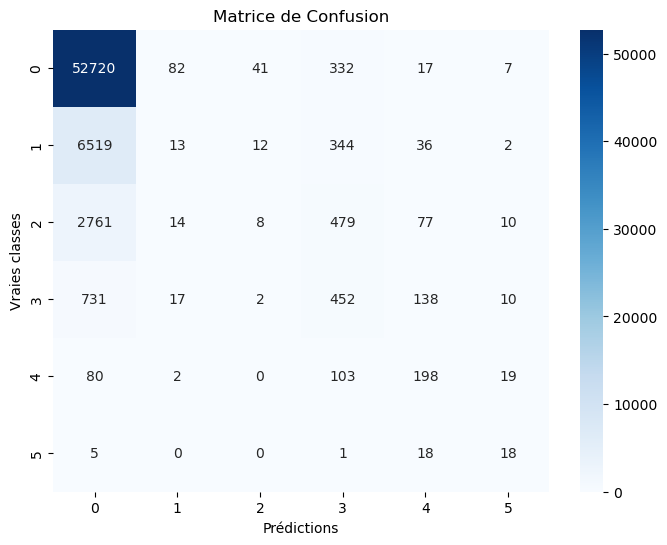

In [ ]:
cm = confusion_matrix(y_test, y_pred_logit_multi_res)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

## LOGISTIC REGRESSION : SMOTE + UNDERSAMPLING

In [ ]:
# SMOTE : on garde la stratégie de sur-échantillonage précente
smote_strategy_bis = {
    2: 13439,
    3: 13000,
    4: 5000,
    5: 1000
}

# Under-sampling : on sous-échantillonne la classe majoritaire 0 à 100k (on pourrait choisir un autre nombre)
under_strategy_bis = {
    0: 100000,
    1: 27626,
    2: 13439,
    3: 13000,
    4: 5000,
    5: 1000
}
resampler_v2 = Pipeline(steps=[
    ("smote", SMOTE(sampling_strategy=smote_strategy, k_neighbors=5, random_state=42)),
    ("under", RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)),
])


In [ ]:
X_train_res_scaled_v2, y_train_res_v2 = resampler_v2.fit_resample(X_train_scaled, y_train)

logit_multi_res_v2 = LogisticRegression(
    penalty="elasticnet", solver="saga", l1_ratio=0.5,
    C=1, max_iter=1000, random_state=42, multi_class="multinomial"
)

logit_multi_res_v2.fit(X_train_res_scaled_v2, y_train_res_v2)

C:\Users\hfsya\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, l1_ratio=0.5, max_iter=1000, multi_class='multinomial',
                   penalty='elasticnet', random_state=42, solver='saga')

In [ ]:
y_pred_logit_multi_res_v2 = logit_multi_res_v2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test, y_pred_logit_multi_res_v2))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     53199
           1       0.22      0.06      0.09      6926
           2       0.20      0.02      0.03      3349
           3       0.21      0.43      0.28      1350
           4       0.39      0.50      0.43       402
           5       0.25      0.43      0.32        42

    accuracy                           0.80     65268
   macro avg       0.35      0.40      0.34     65268
weighted avg       0.74      0.80      0.76     65268



Constat :

*   En se basant sur le f1-score, le recall et la précision, les résultats en faisant SMOTE + UNDERSAMPLING restent relavtievement similaires
*   Par conséquent un des leviers de décision est le temps de calcul qui est nettement plus court sur la méthode SMOTE + UNDERSAMPLING.



In [ ]:
y_proba_logit_multi_res_v2 = logit_multi_res_v2.predict_proba(X_test_scaled)

In [ ]:
auc_macro_ovr_logit_multi_res_v2 = roc_auc_score(y_test, y_proba_logit_multi_res_v2, multi_class="ovr", average="macro",labels=logit_multi_res_v2.classes_)
print("AUC macro OVR =", auc_macro_ovr_logit_multi_res_v2)

AUC macro OVR = 0.8571918778382358


In [ ]:
for k in range(0,6):
    y_true_bin = (y_test == k).astype(int)
    y_score_k = y_proba_logit_multi_res_v2[:, k]

    fpr, tpr, _ = roc_curve(y_true_bin, y_score_k)
    print("AUC classe", k, "=", auc(fpr, tpr))

AUC classe 0 = 0.7958552938048902
AUC classe 1 = 0.7020584201377297
AUC classe 2 = 0.791094946662394
AUC classe 3 = 0.8908628300380232
AUC classe 4 = 0.9669965238709484
AUC classe 5 = 0.9962832525154298


Comme pour les métriques précéntes, les AUC par classe et macro restent similaires.

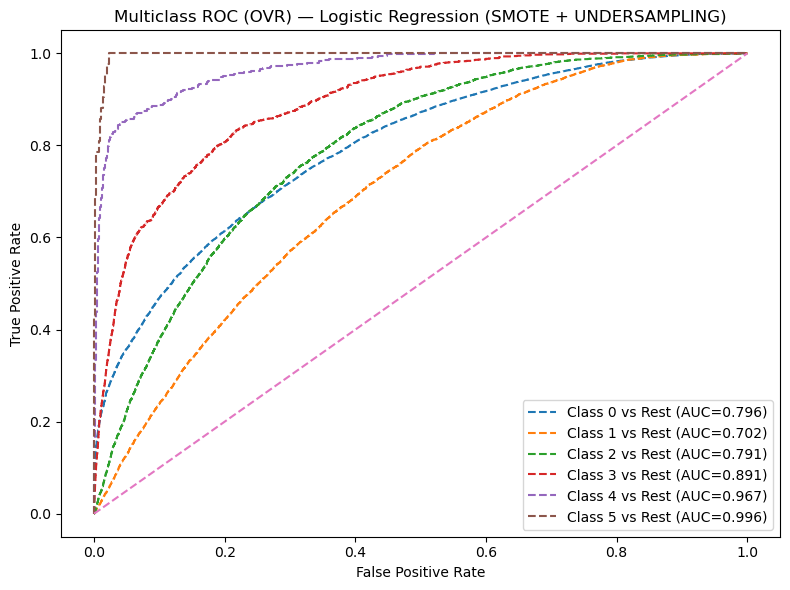

In [ ]:
# Important : ordre des classes correspondant aux colonnes
classes = logit_multi_res_v2.classes_
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))

for j, c in enumerate(classes):
    # y_true binaire pour la classe c
    y_true_bin = y_test_bin[:, j]

    # Si la classe est absente du test, ROC non définie
    if y_true_bin.sum() == 0:
        print(f"Classe {c} absente dans y_test -> ROC/AUC non définie")
        continue

    # score 1D = proba de la classe c
    y_score = y_proba_logit_multi_res_v2[:, j]

    fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score)
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], linestyle="--", label=f"Class {c} vs Rest (AUC={roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline
plt.title("Multiclass ROC (OVR) — Logistic Regression (SMOTE + UNDERSAMPLING)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("multiclass_roc_rf_smote_under_v2.png", dpi=300)
plt.show()


Conclusion sur Logistic Regression :

*   Les résultats entre la méthode SMOTE et SMOTE + UNDERSAMPLING sont similaires.
*   La deusième méthode permet de réduire le temps de calcul, on va donc préférer cette méthode.
*   Les résultats sont, comparés au classificateur Random Forest, nettement moins bons.



Pistes d'amélioration :

*   On pourrait choisir le nombre des k plus proches voisins de façon automatique ou alors faire plusieurs tests avec differentes valeurs.

*   Intuitivement, le paramètre k_neighbors (5 = valeur par défault) contrôle la manière dont les points synthétiques sont générés : plus k est petit, plus on génère “localement” (utile quand une classe est très rare) ; plus k est grand, plus on lisse (mais on peut mélanger des zones différentes).

*   Dans la partie modélisation on pourrait faire du tuning sur les hyperparamètres.

*   Faire plus de tests d'échantillonage afin d'avoir le modèle le plus performant. Dans notre cas nous avons jugé que les résultats obtenus étaient suffisamment bons, mais cela peut être justifié en réalisant cette étude.






